SIDE NOTE: would love to get any critiques, hints, tips, oberservations on any level not just on ML (but obviously ML as the priority).  Beginner Python learner (though I took the Full Stack Course) so any suggestions there are welcome.  Thanks.

Will need to import these libs plus setting some global variables

In [1]:
import sys
import os
import numpy as np
import renders as rs
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.externals import joblib
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import SVC
import matplotlib.cm as cm
# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Might need to change the path of the included libraries.
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/match_stats.py')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/form_model.py')
sys.path.append('/anaconda/envs/stats/lib/python3.5/site-packages')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/model_libs.py')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/form_data.py')
sys.path.append('/Users/senzari/Machine_Learning/stats')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats')
# print(sys.path)
os.chdir('/Users/senzari/Machine_Learning/stats/src')
#print(os.getcwd())

from stats import form_data, match_stats, model_libs, form_model, predict_matches

# Variables
round_number = 27 # for MLS only
target_col = 'points'
ignore_cols = ['games_played', 'match_id', 'team_id', 'team_name', 'opp_id', 'opp_name', 'scheduled']
models = ['log', 'svc', 'gmm', 'knn', 'gnb']

""" this variable 'testing' should be false if using CSV's and not pulling from the database. """
testing = False

INITIALIZED...


Pulling in the data either from the Database or the CSV (CSV for testers).  Data has some added features in between the database and 'raw_data'.  Essentially trying 3 different versions of the data in this set.  One version contains all the features.  Another version has the standard features plus the calculated features of the home/away stats for a matchup.  The last version has the standard features plus the 'extended features' which not only includes the stats of the two teams in the match up but also the current teams previous opponents and the current teams opponents of the team opponents in that matchup.

In [2]:
match_details = form_data.get_coverage()
display(match_details.head())

match_id           scheduled  round             home_team  home_id  \
0         1 2016-03-06 18:30:00      1          NY Red Bulls       31   
1         2 2016-03-06 19:00:00      1       Orlando City SC       35   
2         3 2016-03-06 19:00:00      1          Chicago Fire       40   
3         4 2016-03-06 20:00:00      1        Houston Dynamo       38   
4         5 2016-03-06 20:00:00      1  San Jose Earthquakes       32   

  home_formation  home_score  home_points  home_first_half_score  \
0        4-2-3-1           0            0                      0   
1          4-3-3           2            1                      0   
2        4-2-3-1           3            0                      1   
3        4-2-3-1           3            1                      1   
4          4-4-2           1            3                      0   

   home_second_half_score       ...         away_attacks  away_ball_safe  \
0                       0       ...                  111             128   
1                       2       ...                  NaN              50   
2                       2       ...                  103              75   
3                       2       ...                   74              75   
4                       1       ...                   86              80   

   away_corner_kicks  away_dangerous_attacks  away_fouls  away_offsides  \
0                  4                      50           9              5   
1                  2                      34          11              1   
2                  1                      48           9              1   
3                  2                      51          17              4   
4                  5                      39          15              2   

   away_yellow_card  away_shots_on_target  away_shots_total  away_possession  
0                 2                     6                10               52  
1                 2                     4                 8               50  
2                 2                     8                12               66  
3                 2                     6                13               52  
4                 2                     6                11               48  

[5 rows x 37 columns]

In [25]:
home_score = pd.crosstab(match_details['home_score'], 
            match_details.replace({'home_points': {0: 'Lose', 1: 'Tie', 3: 'Win'}})['home_points']).apply(lambda r: r/len(match_details), axis=1)
home_score['Total'] = home_score.sum(axis=1)
home_score.loc['Total']= home_score.sum()
display(home_score)

home_points      lose       tie       win     Total
home_score                                         
0            0.116162  0.068182  0.000000  0.184343
1            0.088384  0.141414  0.116162  0.345960
2            0.017677  0.070707  0.181818  0.270202
3            0.007576  0.010101  0.111111  0.128788
4            0.000000  0.005051  0.040404  0.045455
5            0.000000  0.000000  0.015152  0.015152
6            0.000000  0.000000  0.010101  0.010101
Total        0.229798  0.295455  0.474747  1.000000

In [26]:
away_score = pd.crosstab(match_details['away_score'], 
            match_details.replace({'away_points': {0: 'Lose', 1: 'Tie', 3: 'Win'}})['away_points']).apply(lambda r: r/len(match_details), axis=1)

away_score['Total'] = away_score.sum(axis=1)
away_score.loc['Total'] = away_score.sum()
display(away_score)

away_points      lose       tie       win     Total
away_score                                         
0            0.242424  0.068182  0.000000  0.310606
1            0.161616  0.141414  0.050505  0.353535
2            0.060606  0.070707  0.090909  0.222222
3            0.007576  0.010101  0.053030  0.070707
4            0.002525  0.005051  0.032828  0.040404
7            0.000000  0.000000  0.002525  0.002525
Total        0.474747  0.295455  0.229798  1.000000

In [27]:
away_shots = pd.crosstab(match_details['away_score'], 
            match_details['away_shots_total'])

away_shots['Total'] = away_shots.sum(axis=1)
away_shots.loc['Total'] = away_shots.sum()
display(away_shots)

away_shots_total  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  11.0  \
away_score                                                                  
0                   2    1    2    9   13   15   13   15   17    10    11   
1                   0    2    7   13   10   19   25    9   17     9     8   
2                   0    0    1    5    4    6   12    9   11    14     7   
3                   0    0    0    1    0    1    5    6    4     2     2   
4                   0    0    0    1    1    0    3    0    2     0     2   
Total               2    3   10   29   28   41   58   39   51    35    30   

away_shots_total  12.0  13.0  14.0  15.0  16.0  17.0  18.0  Total  
away_score                                                         
0                    3     4     0     0     0     2     0    117  
1                    4     3     3     0     1     0     1    131  
2                    3     4     2     2     2     1     1     84  
3                    2     2     0     0     1     0     0     26  
4                    3     1     1     0     1     0     0     15  
Total               15    14     6     2     5     3     2    373

In [28]:
home_shots = pd.crosstab(match_details['home_score'], 
            match_details['home_shots_total'])

home_shots['Total'] = home_shots.sum(axis=1)
home_shots.loc['Total'] = home_shots.sum()
display(home_shots)

home_shots_total  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  \
home_score                                                                 
0                   1    1    1    1    1    5    7    7   14    8     3   
1                   0    1    1    4    3    6    8    9   13   15    23   
2                   0    0    0    2    1    5    5    5    7   11     9   
3                   0    0    0    0    0    1    2    2    2    4     7   
4                   0    0    0    0    0    0    1    1    0    2     4   
5                   0    0    0    0    0    0    1    0    0    1     2   
6                   0    0    0    0    0    0    0    0    0    0     0   
Total               1    2    2    7    5   17   24   24   36   41    48   

home_shots_total  11.0  12.0  13.0  14.0  15.0  16.0  17.0  18.0  19.0  20.0  \
home_score                                                                     
0                    6     6     2     2     1     1     0     1     0     0   
1                    9    15     6     5     2     3     2     2     1     0   
2                   14    14    13     6     2     3     1     0     0     2   
3                    5     7     4     7     2     3     0     1     0     2   
4                    0     1     2     1     1     2     0     0     0     0   
5                    0     0     0     0     0     0     0     1     0     0   
6                    0     1     0     0     1     0     0     1     0     0   
Total               34    44    27    21     9    12     3     6     1     4   

home_shots_total  21.0  24.0  Total  
home_score                           
0                    0     0     68  
1                    0     0    128  
2                    1     1    102  
3                    0     0     49  
4                    0     1     16  
5                    1     0      6  
6                    1     0      4  
Total                3     2    373

## Extended Features RELATIONSHIPS

e_f_shots_on_target  e_f_ball_safe  e_f_possession  e_f_attacks  \
0             9.000000      87.000000       46.000000    93.000000   
1             6.500000      79.000000       49.000000    95.000000   
2             6.666667      85.333333       50.333333   103.333333   
3             6.500000      92.750000       49.500000   107.250000   
4             6.400000      88.800000       49.200000   105.800000   

   e_f_dangerous_attacks  e_f_shots_total  points  
0              59.000000        12.000000       0  
1              55.000000         9.000000       3  
2              60.666667        11.666667       3  
3              57.000000        11.000000       1  
4              55.600000        12.600000       1

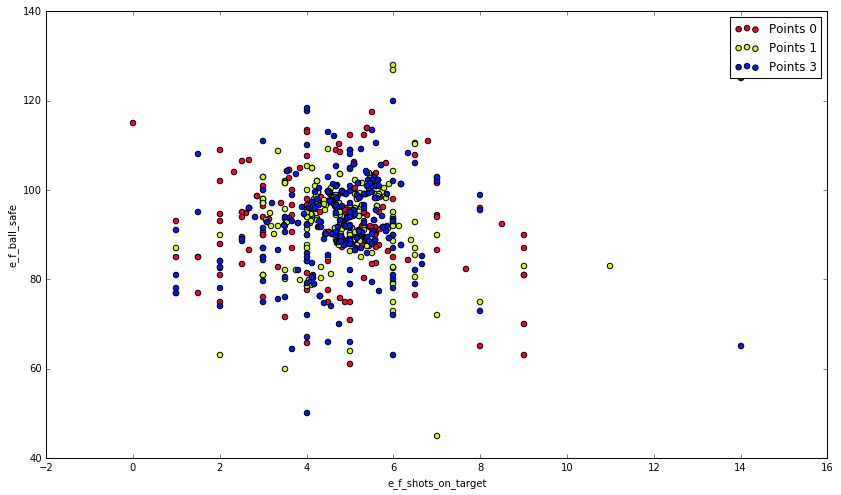

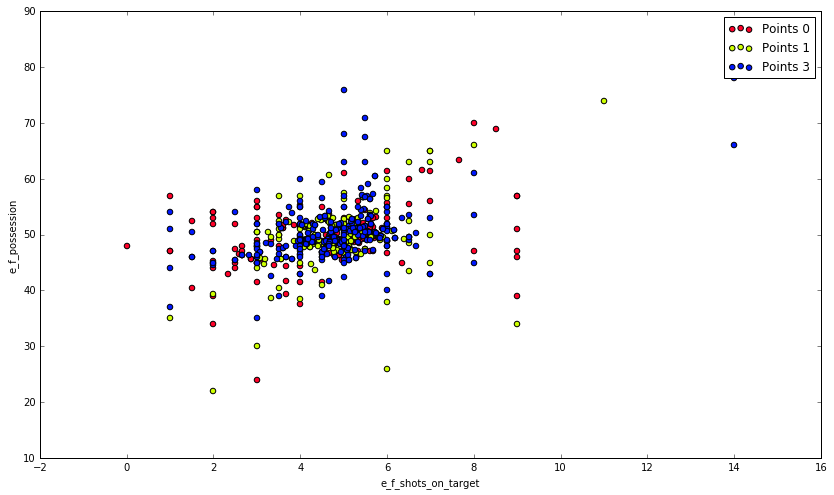

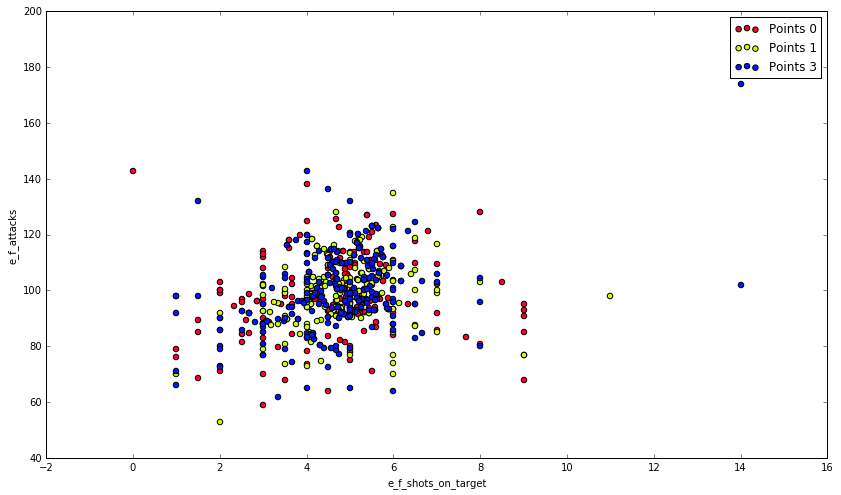

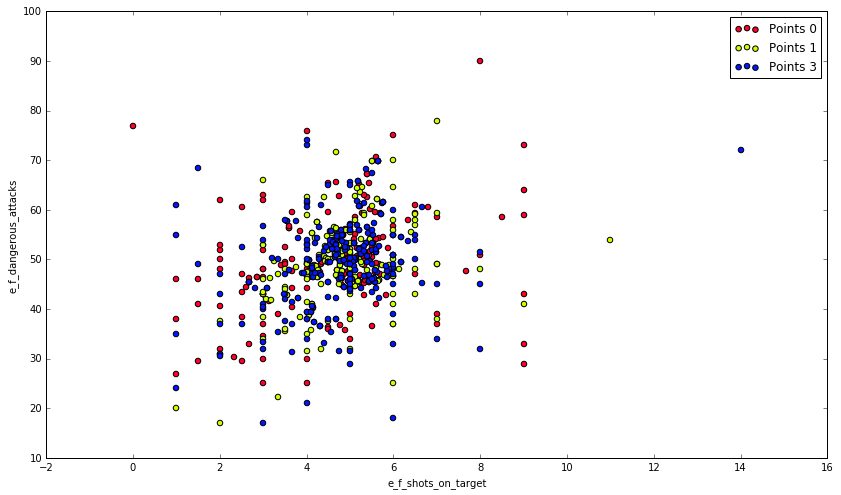

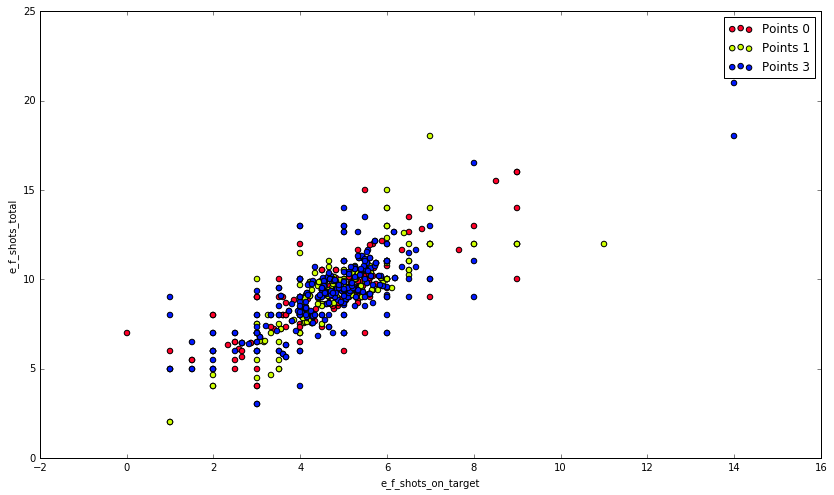

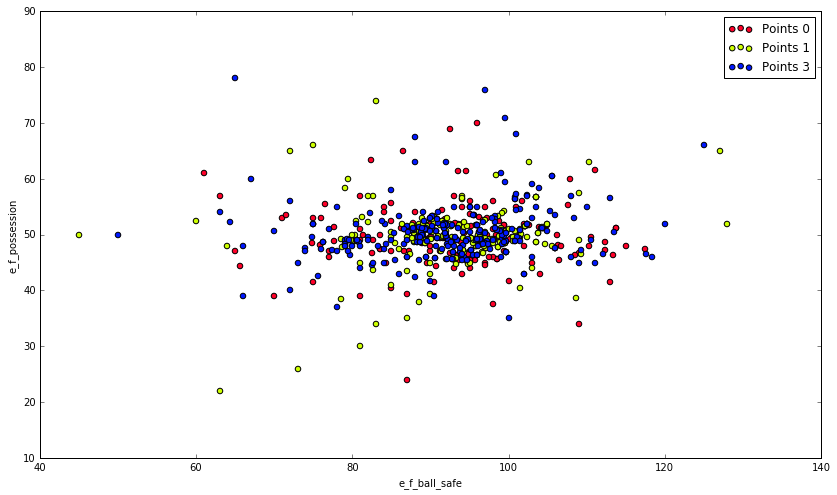

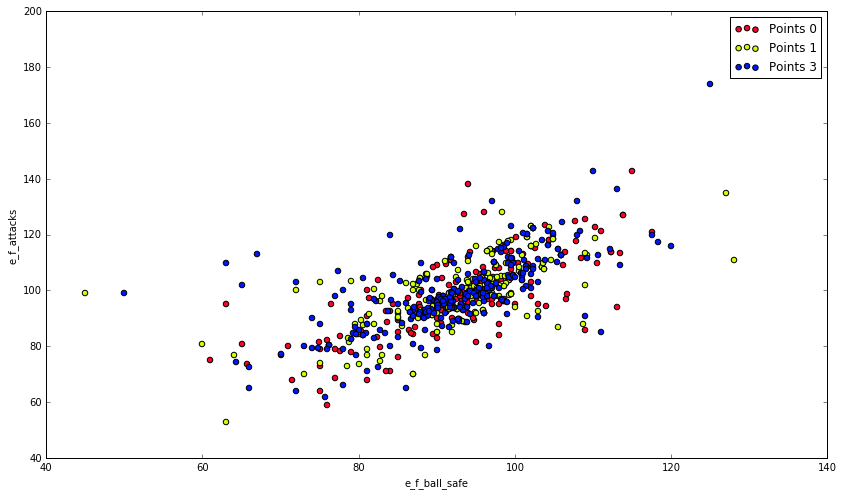

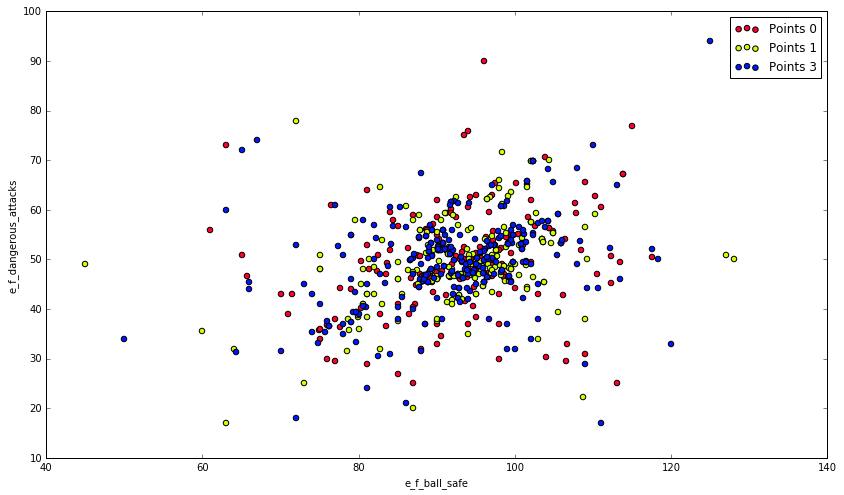

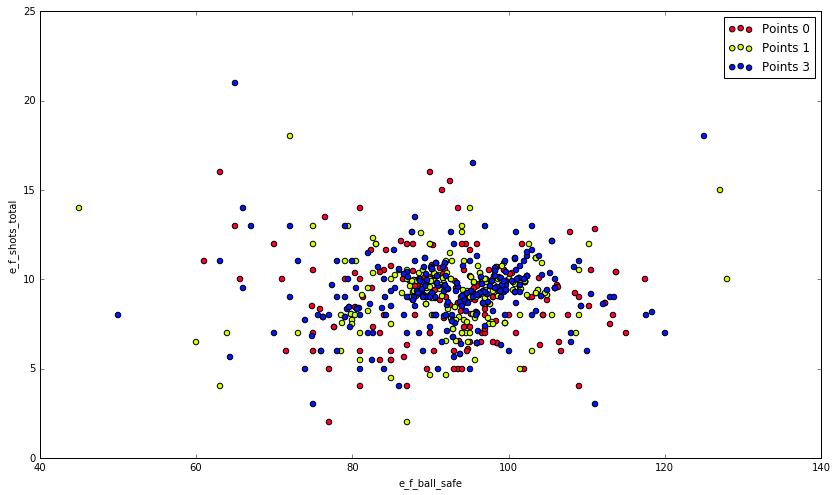

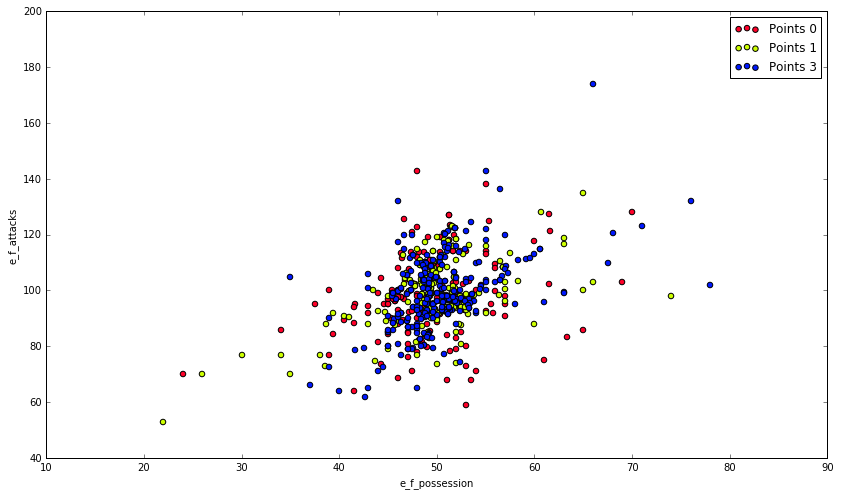

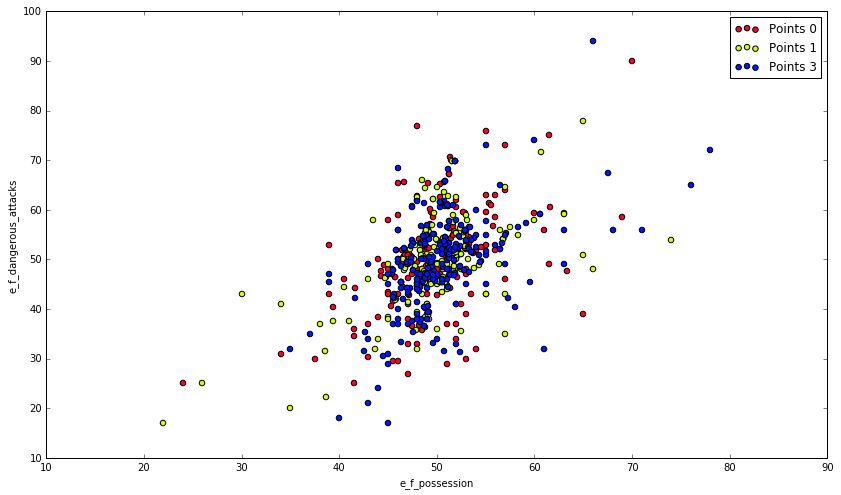

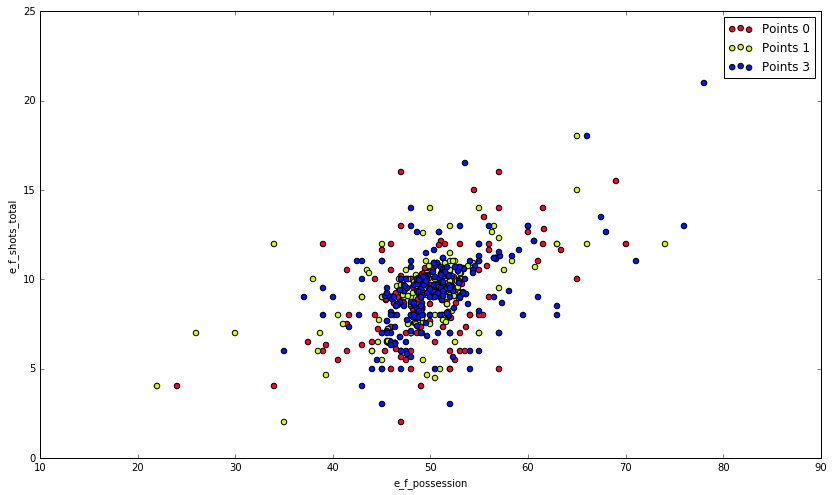

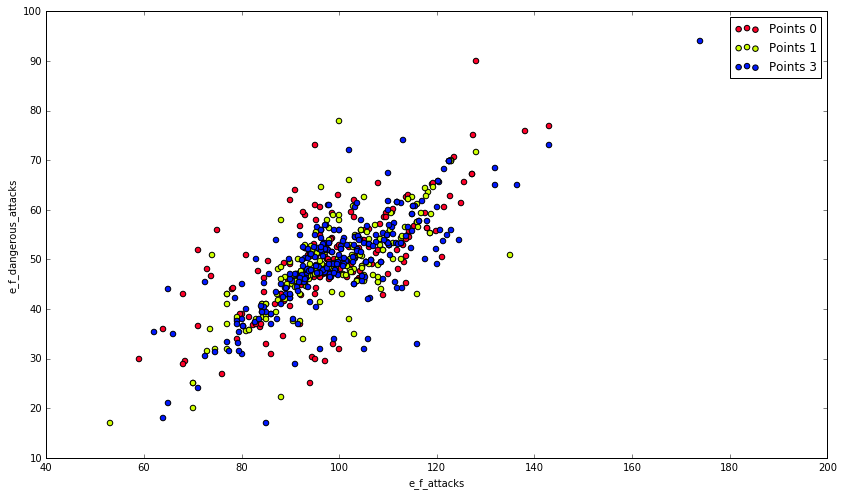

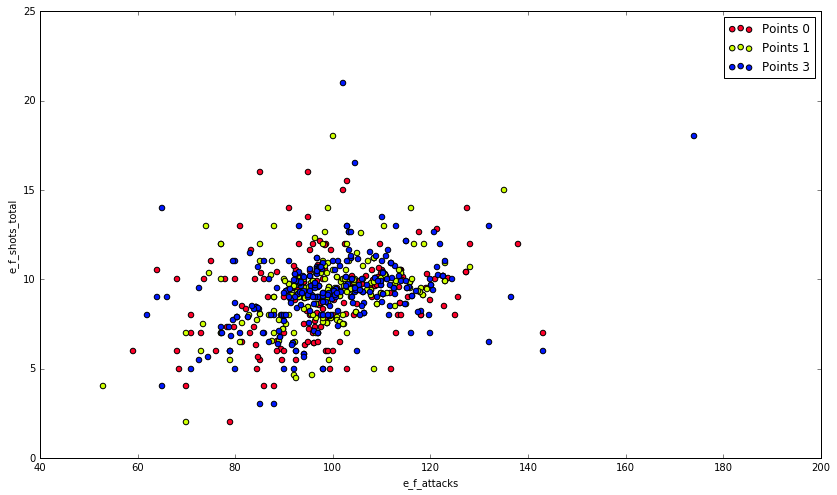

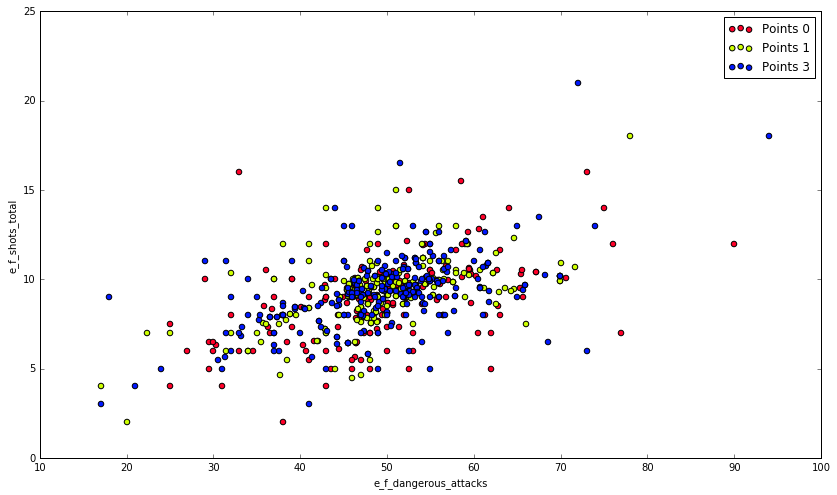

In [12]:
columns = ['e_f_shots_on_target', 'e_f_ball_safe', 'e_f_possession', 'e_f_attacks', 'e_f_dangerous_attacks', 'e_f_shots_total', 
           'points']
extended_features = raw_data[columns]
display(extended_features.head())

for c in range(len(columns)):
    if c < (len(columns)-1): 
        compare = (len(columns)-2) - c
        for x in (range(compare)):
            fig, ax = plt.subplots(figsize = (14,8))
            cmap = cm.get_cmap('gist_rainbow')

            for i, cluster in extended_features.groupby('points'):   
                cluster.plot(ax = ax, kind = 'scatter', x = columns[c], y = columns[x+1+c], 
                    color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);


home_attacks  home_ball_safe  home_points
0           143             115            0
2            77              83            0
3            65              66            1
4            88              75            3
5            93              87            3

(372, 3)


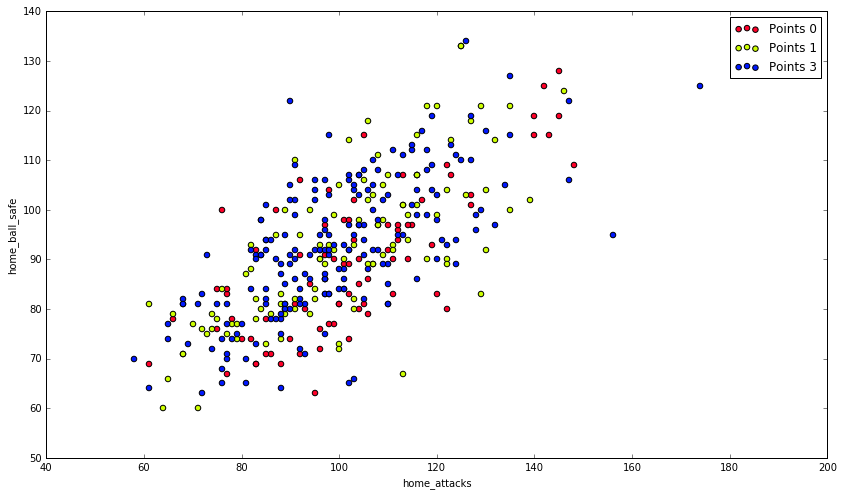

In [13]:
#print(match_details)
cols = ['home_attacks', 'home_ball_safe', 'home_points']
rels = match_details[cols]
rels = rels.dropna()
display(rels.head())
print(rels.shape)

fig, ax = plt.subplots(figsize = (14,8))
cmap = cm.get_cmap('gist_rainbow')

for i, cluster in rels.groupby('home_points'):   
    cluster.plot(ax = ax, kind = 'scatter', x = 'home_attacks', y = 'home_ball_safe', 
                    color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);

away_attacks  away_ball_safe  away_points
0           111             128            3
2           103              75            3
3            74              75            1
4            86              80            0
5            92              91            0

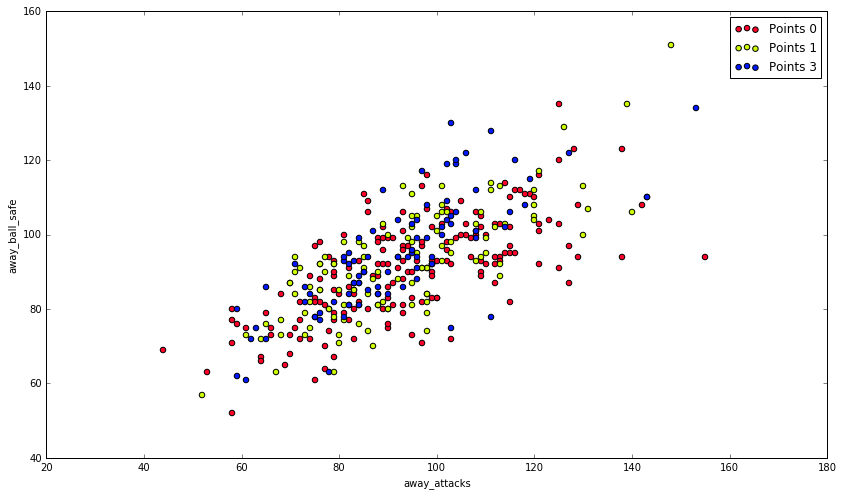

In [14]:
#print(match_details)
cols = ['away_attacks', 'away_ball_safe', 'away_points']
rels = match_details[cols]
rels = rels.dropna()
display(rels.head())

fig, ax = plt.subplots(figsize = (14,8))
cmap = cm.get_cmap('gist_rainbow')

for i, cluster in rels.groupby('away_points'):   
    cluster.plot(ax = ax, kind = 'scatter', x = 'away_attacks', y = 'away_ball_safe', 
                    color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);

home_score         0    1    2   3   4  5  6  Total
home_shots_total                                   
0.0                1    0    0   0   0  0  0      1
1.0                1    1    0   0   0  0  0      2
2.0                1    1    0   0   0  0  0      2
3.0                1    4    2   0   0  0  0      7
4.0                1    3    1   0   0  0  0      5
5.0                5    6    5   1   0  0  0     17
6.0                7    8    5   2   1  1  0     24
7.0                7    9    5   2   1  0  0     24
8.0               14   13    7   2   0  0  0     36
9.0                8   15   11   4   2  1  0     41
10.0               3   23    9   7   4  2  0     48
11.0               6    9   14   5   0  0  0     34
12.0               6   15   14   7   1  0  1     44
13.0               2    6   13   4   2  0  0     27
14.0               2    5    6   7   1  0  0     21
15.0               1    2    2   2   1  0  1      9
16.0               1    3    3   3   2  0  0     12
17.0               0    2    1   0   0  0  0      3
18.0               1    2    0   1   0  1  1      6
19.0               0    1    0   0   0  0  0      1
20.0               0    0    2   2   0  0  0      4
21.0               0    0    1   0   0  1  1      3
24.0               0    0    1   0   1  0  0      2
Total             68  128  102  49  16  6  4    373

home_score         0   1   2   3  4  5  6  Total
home_shots_total                                
8.0               14  13   7   2  0  0  0     36
9.0                8  15  11   4  2  1  0     41
10.0               3  23   9   7  4  2  0     48
11.0               6   9  14   5  0  0  0     34
12.0               6  15  14   7  1  0  1     44
Total             37  75  55  25  7  3  1    203

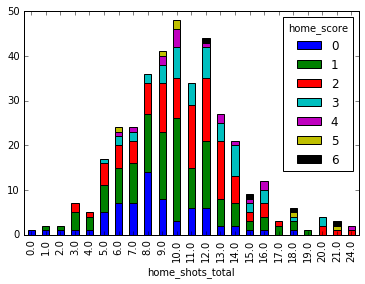

In [57]:
cols = ['home_shots_total', 'home_score', 'home_points']
rels = match_details[cols]
rels = rels.dropna()
# print(rels.groupby('home_shots_total').groups)
rels = rels.sort_values('home_shots_total')

a = pd.crosstab(rels['home_shots_total'], rels['home_score'])
a.plot(kind='bar', stacked=True)
a['Total'] = a.sum(axis=1)
a.loc['Total']= a.sum()
display(a)

b = pd.crosstab(rels['home_shots_total'], rels['home_score'])
b = b.loc[8:12]
b['Total'] = b.sum(axis=1)
b.loc['Total']= b.sum()
display(b)

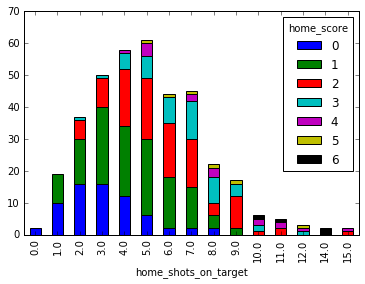

In [29]:
cols = ['home_shots_on_target', 'home_score', 'home_points']
rels = match_details[cols]
rels = rels.dropna()

rels = rels.sort_values('home_shots_on_target')

temp = pd.crosstab(rels['home_shots_on_target'], rels['home_score'])
temp.plot(kind='bar', stacked=True)

away_score          0    1   2   3   4  Total
away_shots_total                             
1.0                 2    0   0   0   0      2
2.0                 1    2   0   0   0      3
3.0                 2    7   1   0   0     10
4.0                 9   13   5   1   1     29
5.0                13   10   4   0   1     28
6.0                15   19   6   1   0     41
7.0                13   25  12   5   3     58
8.0                15    9   9   6   0     39
9.0                17   17  11   4   2     51
10.0               10    9  14   2   0     35
11.0               11    8   7   2   2     30
12.0                3    4   3   2   3     15
13.0                4    3   4   2   1     14
14.0                0    3   2   0   1      6
15.0                0    0   2   0   0      2
16.0                0    1   2   1   1      5
17.0                2    0   1   0   0      3
18.0                0    1   1   0   0      2
Total             117  131  84  26  15    373

away_score         0   1   2   3  4  Total
away_shots_total                          
6.0               15  19   6   1  0     41
7.0               13  25  12   5  3     58
8.0               15   9   9   6  0     39
9.0               17  17  11   4  2     51
10.0              10   9  14   2  0     35
Total             70  79  52  18  5    224

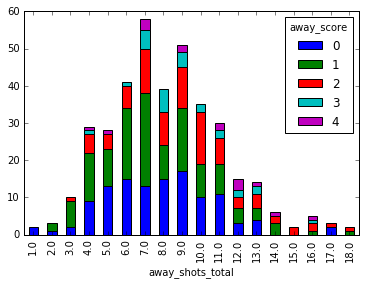

In [56]:
cols = ['away_shots_total', 'away_score', 'away_points']
rels = match_details[cols]
rels = rels.dropna()

a = pd.crosstab(rels['away_shots_total'], rels['away_score'])
a.plot(kind='bar', stacked=True)
a['Total'] = a.sum(axis=1)
a.loc['Total']= a.sum()
display(a)


b = pd.crosstab(rels['away_shots_total'], rels['away_score'])
b = b.loc[6:10]
b['Total'] = b.sum(axis=1)
b.loc['Total']= b.sum()
display(b)

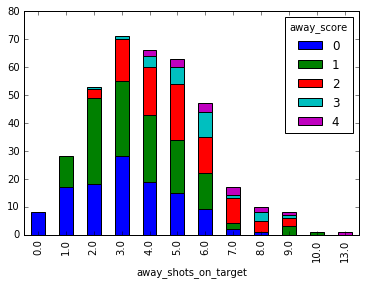

In [30]:
cols = ['away_shots_on_target', 'away_score', 'away_points']
rels = match_details[cols]
rels = rels.dropna()

rels = rels.sort_values('away_shots_on_target')

temp = pd.crosstab(rels['away_shots_on_target'], rels['away_score'])
temp.plot(kind='bar', stacked=True)

In [17]:
conv_points = match_details
def set_group(goals):
    if goals >= 2:
        return 1
    elif goals < 2:
        return 0
    
conv_points['home_converted_score'] = conv_points.apply(lambda row: set_group(row['home_score']), axis=1)
conv_points = conv_points.drop('home_score', 1)

conv_points['away_converted_score'] = conv_points.apply(lambda row: set_group(row['away_score']), axis=1)
conv_points = conv_points.drop('away_score', 1) 

In [22]:
away_points = pd.crosstab(conv_points['away_converted_score'], 
            conv_points.replace({'away_points': {0: 'Lose', 1: 'Tie', 3: 'Win'}})['away_points']).apply(lambda r: r/len(match_details), axis=1)

away_points['Total'] = away_points.sum(axis=1)
away_points.loc['Total']= away_points.sum()
display(away_points)

away_points               lose       tie       win     Total
away_converted_score                                        
0                     0.404040  0.209596  0.050505  0.664141
1                     0.070707  0.085859  0.179293  0.335859
Total                 0.474747  0.295455  0.229798  1.000000

In [23]:
home_points = pd.crosstab(conv_points['home_converted_score'], 
            conv_points.replace({'home_points': {0: 'Lose', 1: 'Tie', 3: 'Win'}})['home_points']).apply(lambda r: r/len(match_details), axis=1)
home_points['Total'] = home_points.sum(axis=1)
home_points.loc['Total']= home_points.sum()
display(home_points)

home_points               lose       tie       win     Total
home_converted_score                                        
0                     0.204545  0.209596  0.116162  0.530303
1                     0.025253  0.085859  0.358586  0.469697
Total                 0.229798  0.295455  0.474747  1.000000

In [58]:
data_csv = 'round' + str(round_number) + '.csv'

if testing:
    raw_data = form_data.run_data(round_number)
    raw_data.to_csv(data_csv)
    print("Raw Data Saved to CSV")
else:
    #Reading in a CSV adds the first index column
    raw_data = pd.read_csv(data_csv)
    raw_data = raw_data.drop(raw_data.columns[[0]], axis=1)

pd.set_option("display.max_columns", 85)

# Removes Columns to Ignore and Splits the Target Column
def split_target(data):
    td = model_libs._clone_and_drop(data, ignore_cols)
    (y, X) = model_libs._extract_target(td, target_col)
    return X, y

raw_X, raw_y = split_target(raw_data)

display(raw_data.head())

print('Data Loaded...')

match_id  team_id  team_name  opp_id              opp_name  \
0       235       21  FC Dallas      38        Houston Dynamo   
1       241       21  FC Dallas      29       Montreal Impact   
2       249       21  FC Dallas      33             DC United   
3       255       21  FC Dallas      39         Columbus Crew   
4       265       21  FC Dallas      32  San Jose Earthquakes   

             scheduled  games_played  is_home current_formation  avg_points  \
0  2016-03-13 01:30:00             1        0           4-2-3-1        3.00   
1  2016-03-20 01:00:00             2        1           4-2-3-1        1.50   
2  2016-03-26 21:30:00             3        0           4-2-3-1        2.00   
3  2016-04-03 01:00:00             4        1             4-4-2        2.25   
4  2016-04-10 01:00:00             5        1             4-4-2        2.00   

   avg_goals_for  avg_goals_against    margin  goal_diff  win_percentage  \
0       2.000000           0.000000  2.000000          2        1.000000   
1       1.000000           2.500000 -1.500000         -3        0.500000   
2       1.333333           1.666667 -0.333333         -1        0.666667   
3       1.750000           1.250000  0.500000          2        0.777778   
4       1.600000           1.200000  0.400000          2        0.717391   

        sos  opp_is_home opp_formation  opp_avg_points  opp_avg_goals  \
0  1.166667            1       4-2-3-1        1.000000       3.000000   
1  2.000000            0       4-2-3-1        3.000000       3.000000   
2  0.880952            1         4-4-2        0.666667       0.666667   
3  0.500000            0       4-2-3-1        0.333333       0.666667   
4  1.388803            0         4-4-2        1.750000       1.250000   

   opp_margin  opp_goal_diff  opp_win_percentage  opp_opp_record  \
0    0.000000              0            0.500000          0.5000   
1    2.000000              4            1.000000          0.0000   
2   -1.000000             -3            0.357143          0.5000   
3   -0.666667             -2            0.166667          0.3125   
4    0.000000              0            0.617647          0.3000   

   current_team_home_possession  current_team_away_possession  \
0                          46.0                     48.195318   
1                          46.0                     52.000000   
2                          49.5                     52.000000   
3                          49.5                     49.500000   
4                          49.0                     49.500000   

   current_team_home_attacks  current_team_away_attacks  \
0                  93.000000                  96.025639   
1                  93.000000                  97.000000   
2                 106.500000                  97.000000   
3                 106.500000                 108.000000   
4                 104.333333                 108.000000   

   current_team_home_dangerous_attacks  current_team_away_dangerous_attacks  \
0                            59.000000                            46.561958   
1                            59.000000                            51.000000   
2                            65.500000                            51.000000   
3                            65.500000                            48.500000   
4                            60.333333                            48.500000   

   current_team_home_yellow_card  current_team_away_yellow_card  \
0                       1.000000                       1.916176   
1                       1.000000                       3.000000   
2                       1.500000                       3.000000   
3                       1.500000                       2.500000   
4                       1.666667                       2.500000   

   current_team_home_corner_kicks  current_team_away_corner_kicks  \
0                        8.000000                        4.184249   
1                        8.000000                        7.000000   
2

Data Loaded...


current_team_home_possession  current_team_home_attacks  \
0                          46.0                  93.000000   
1                          46.0                  93.000000   
2                          49.5                 106.500000   
3                          49.5                 106.500000   
4                          49.0                 104.333333   

   current_team_home_dangerous_attacks  current_team_home_shots_on_target  \
0                            59.000000                           9.000000   
1                            59.000000                           9.000000   
2                            65.500000                           8.000000   
3                            65.500000                           8.000000   
4                            60.333333                           7.333333   

   current_team_home_shots_total  current_team_home_ball_safe  points  
0                           12.0                         87.0       0  
1                           12.0                         87.0       3  
2                           14.5                         92.5       3  
3                           14.5                         92.5       1  
4                           16.0                         86.0       1

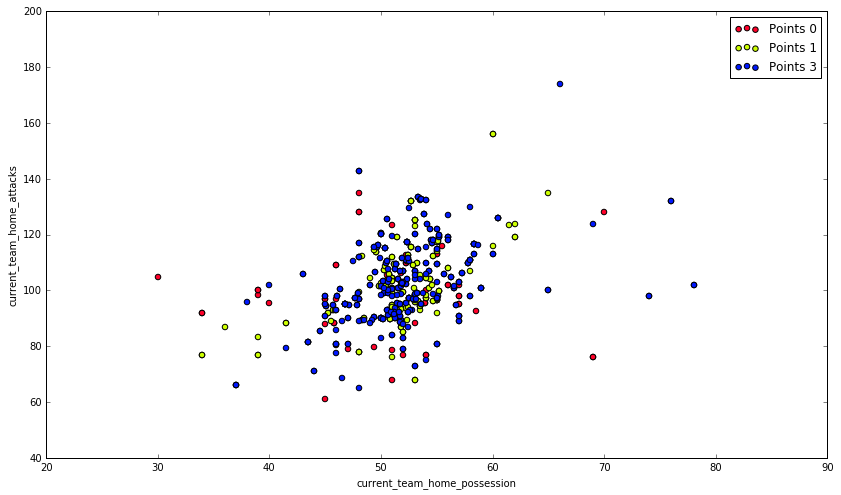

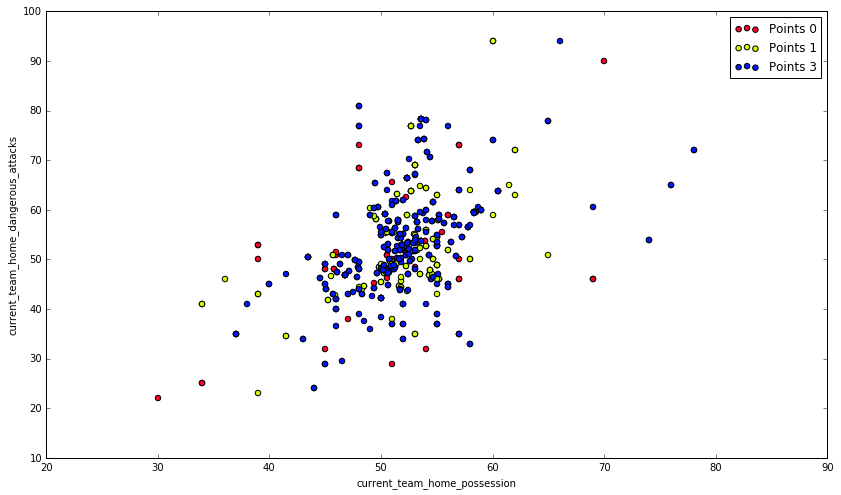

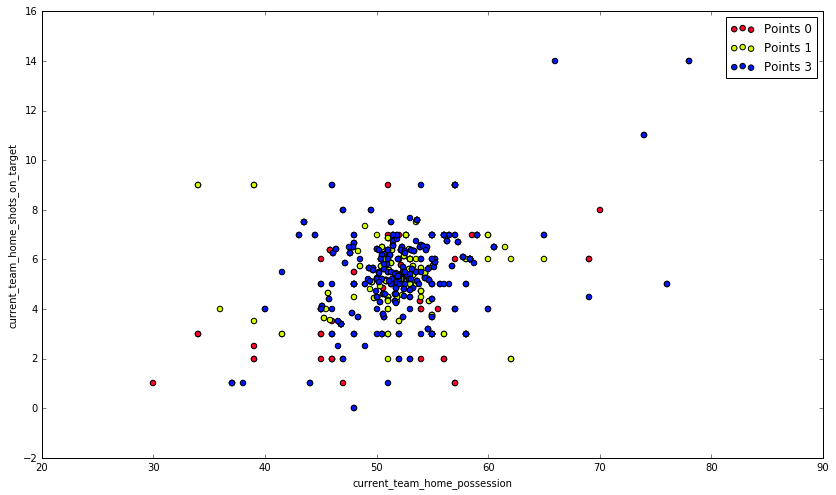

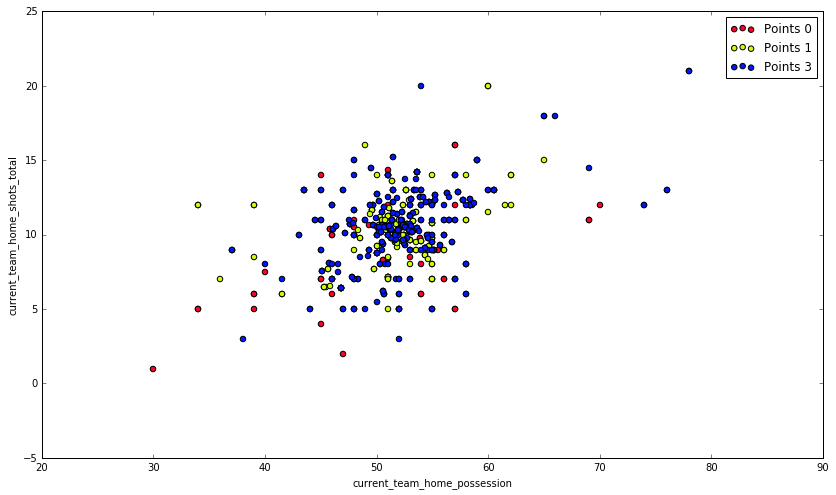

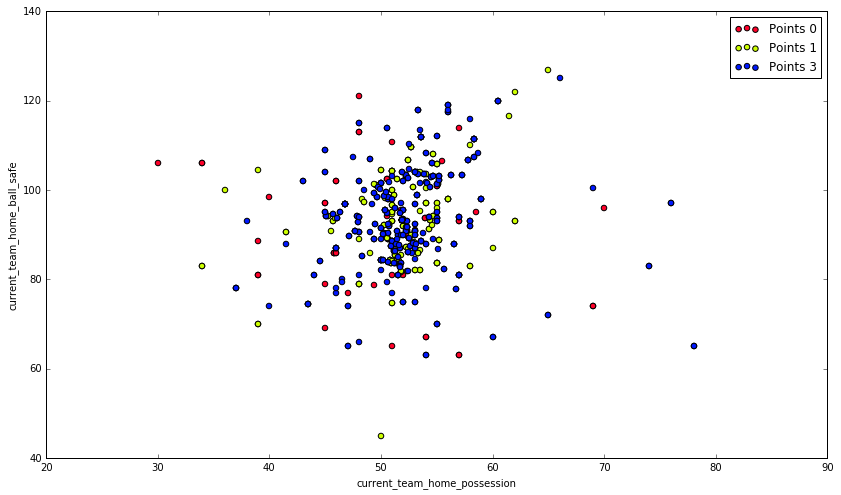

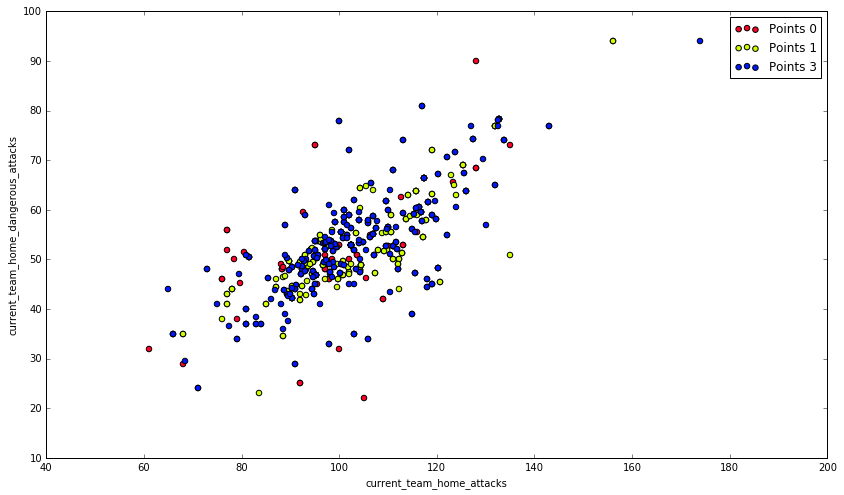

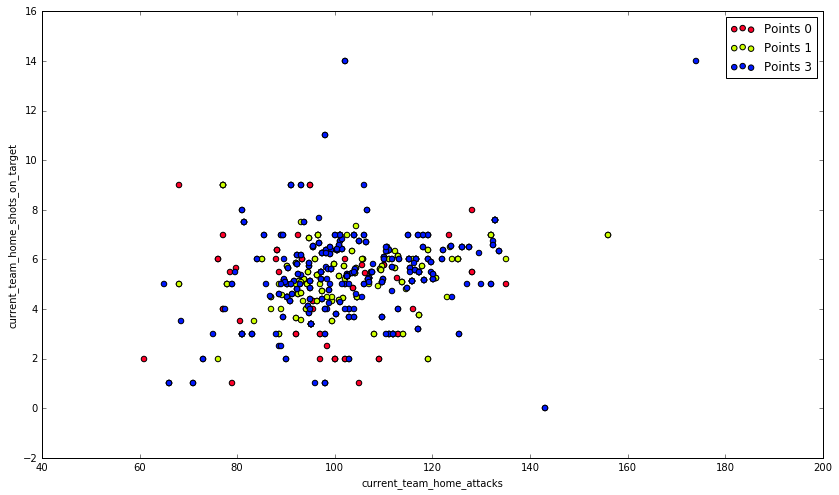

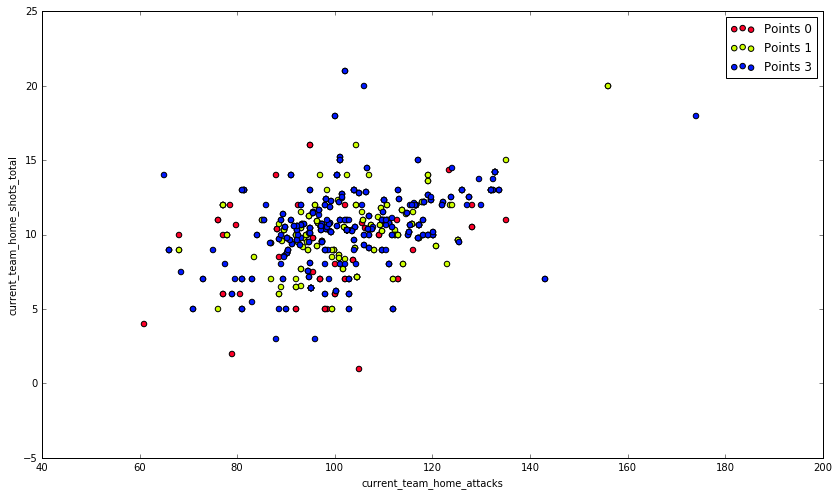

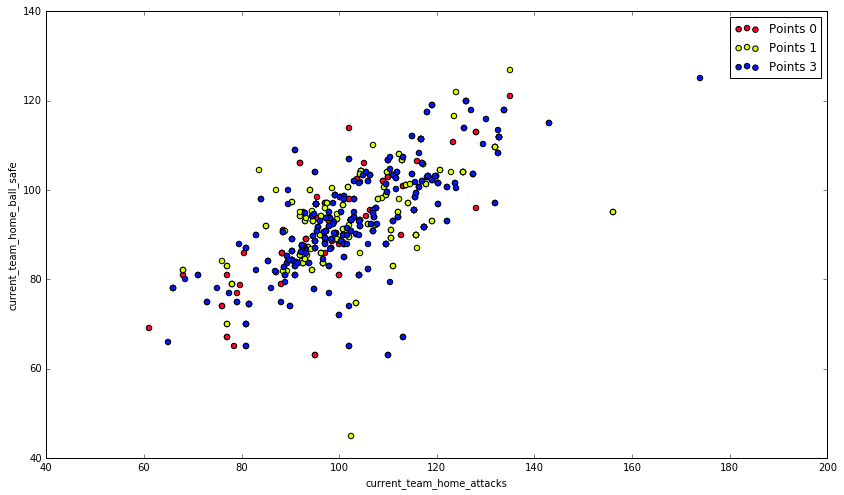

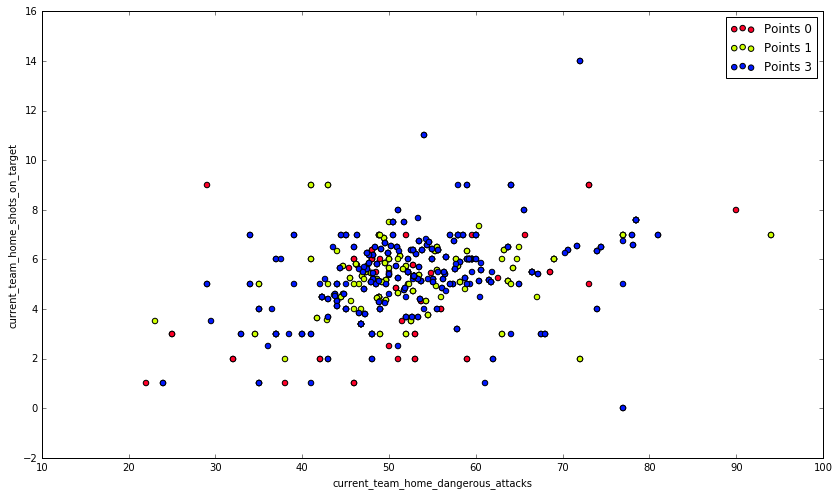

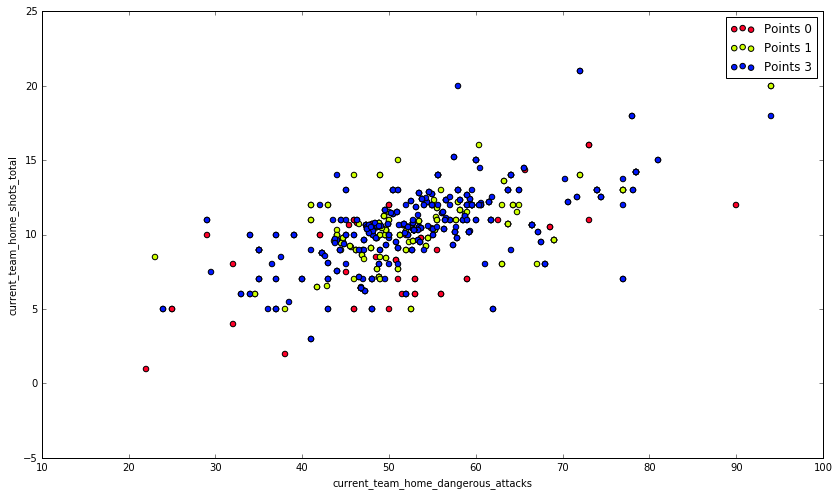

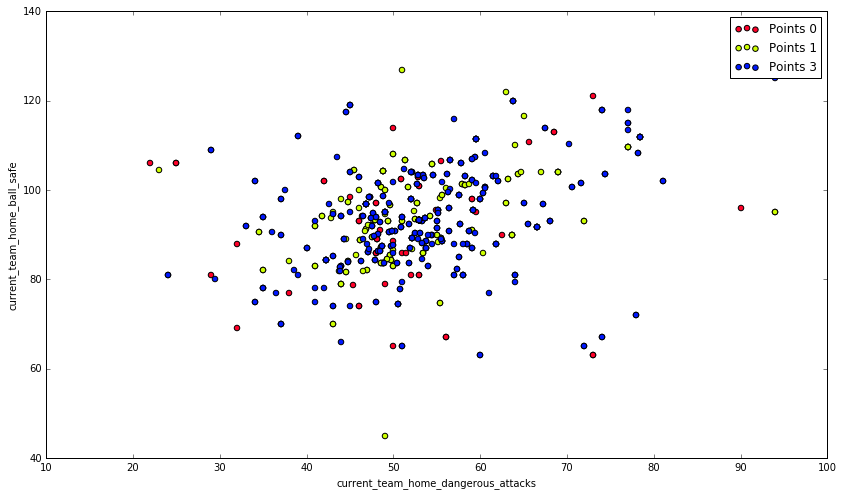

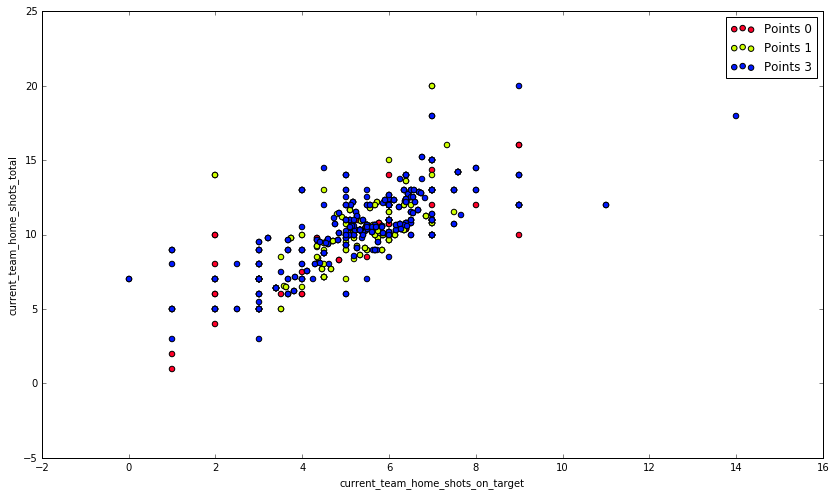

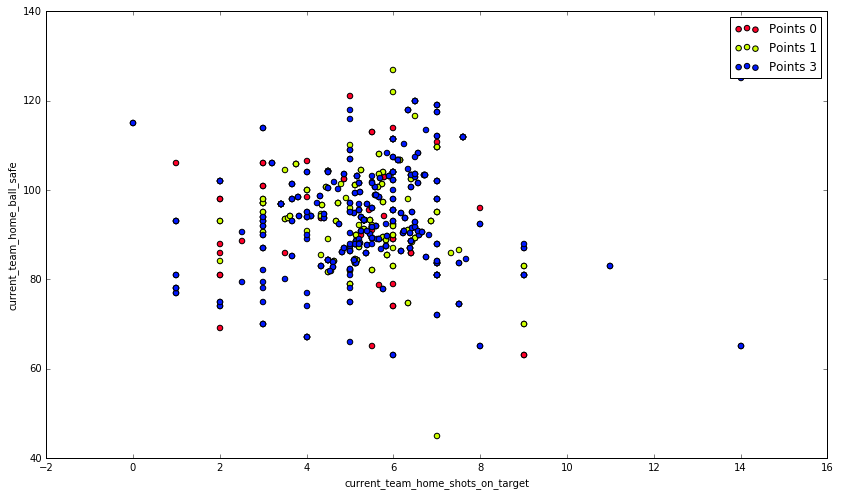

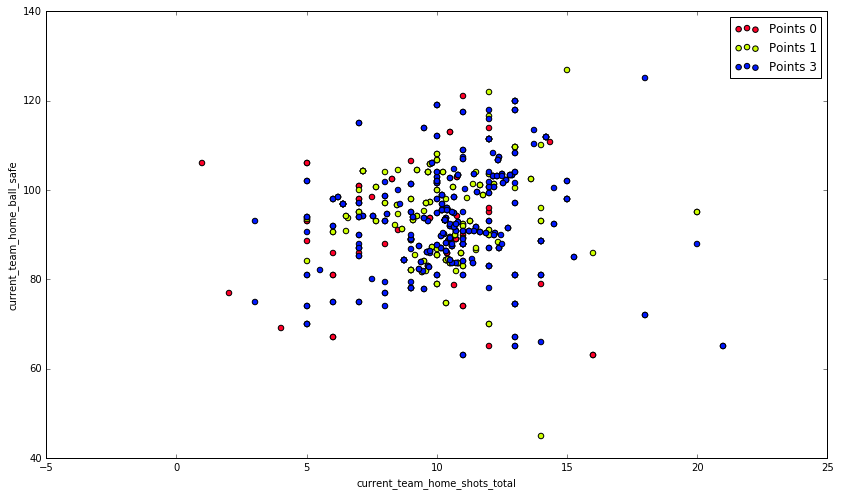

In [60]:
home_columns = ['current_team_home_possession', 'current_team_home_attacks', 'current_team_home_dangerous_attacks', 'current_team_home_shots_on_target', 'current_team_home_shots_total', 'current_team_home_ball_safe', 
           'points']

away_columns = ['current_team_away_possession', 'current_team_away_attacks', 'current_team_away_dangerous_attacks', 'current_team_away_shots_on_target', 'current_team_away_shots_total', 'current_team_away_ball_safe', 
           'points']
extended_features = raw_data[home_columns]
display(extended_features.head())

for c in range(len(home_columns)):
    if c < (len(home_columns)-1): 
        compare = (len(home_columns)-2) - c
        for x in (range(compare)):
            fig, ax = plt.subplots(figsize = (14,8))
            cmap = cm.get_cmap('gist_rainbow')

            for i, cluster in extended_features.groupby('points'):   
                cluster.plot(ax = ax, kind = 'scatter', x = home_columns[c], y = home_columns[x+1+c], 
                    color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);


current_team_away_possession  current_team_away_attacks  \
0                     48.195318                  96.025639   
1                     52.000000                  97.000000   
2                     52.000000                  97.000000   
3                     49.500000                 108.000000   
4                     49.500000                 108.000000   

   current_team_away_dangerous_attacks  current_team_away_shots_on_target  \
0                            46.561958                           4.131807   
1                            51.000000                           4.000000   
2                            51.000000                           4.000000   
3                            48.500000                           5.000000   
4                            48.500000                           5.000000   

   current_team_away_shots_total  current_team_away_ball_safe  points  
0                       8.097396                     92.56133       0  
1                       6.000000                     71.00000       3  
2                       6.000000                     71.00000       3  
3                       7.500000                     93.00000       1  
4                       7.500000                     93.00000       1

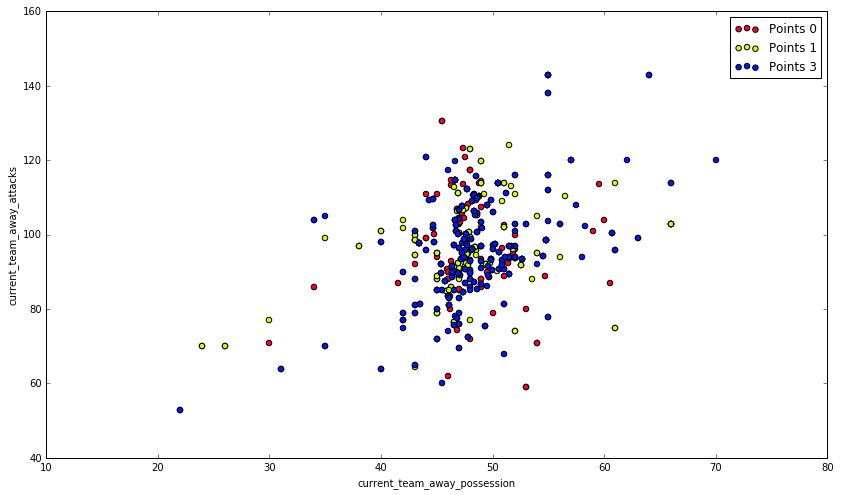

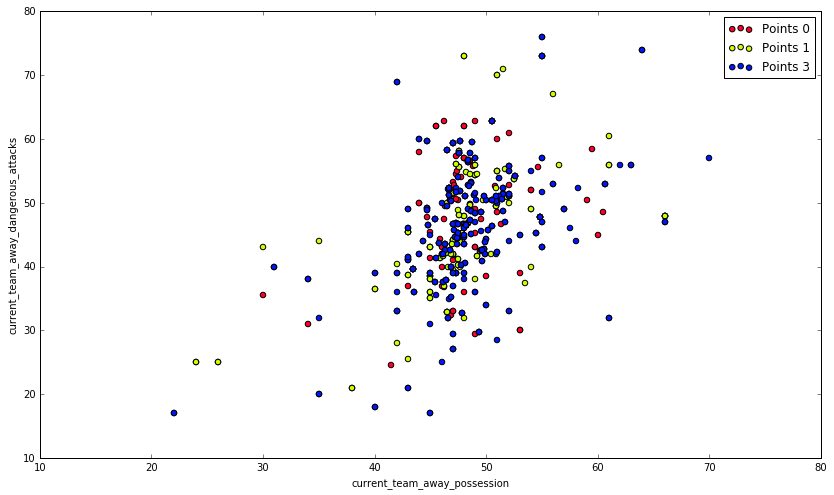

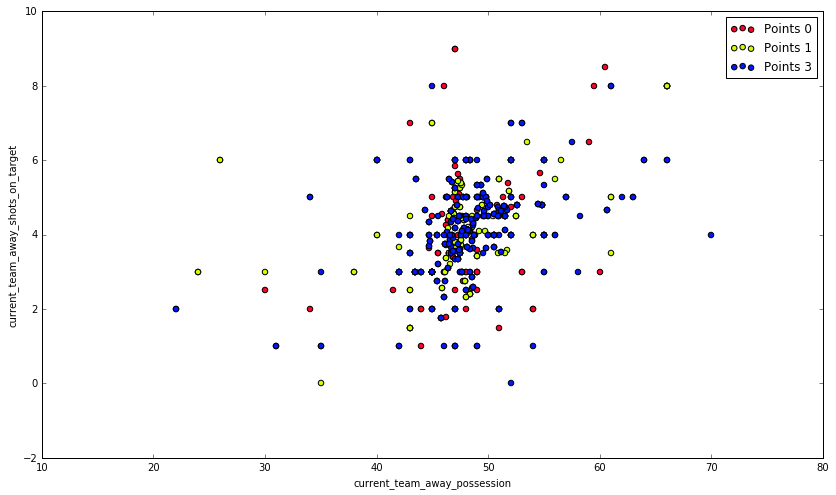

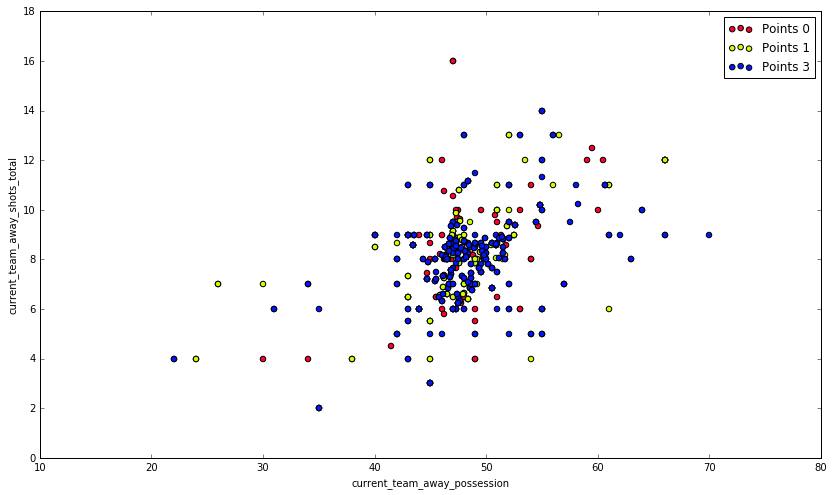

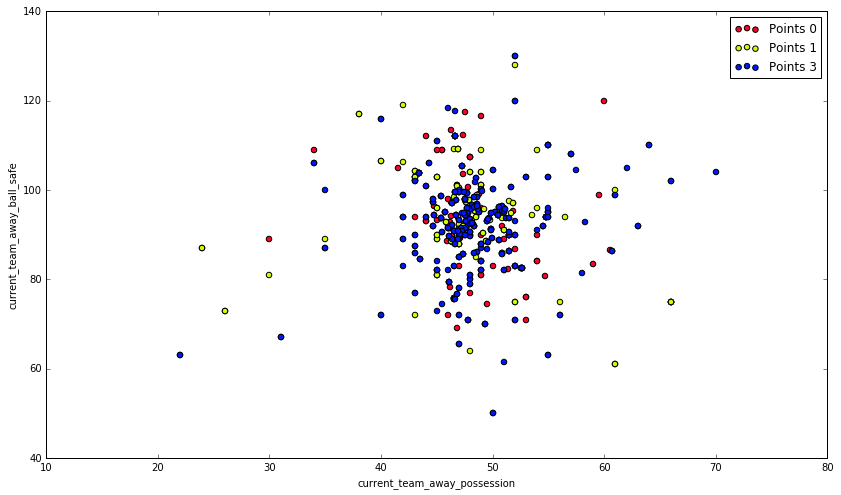

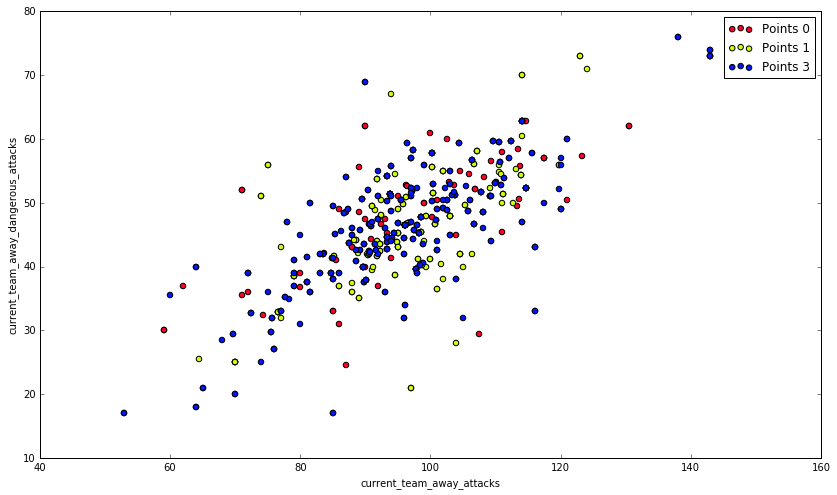

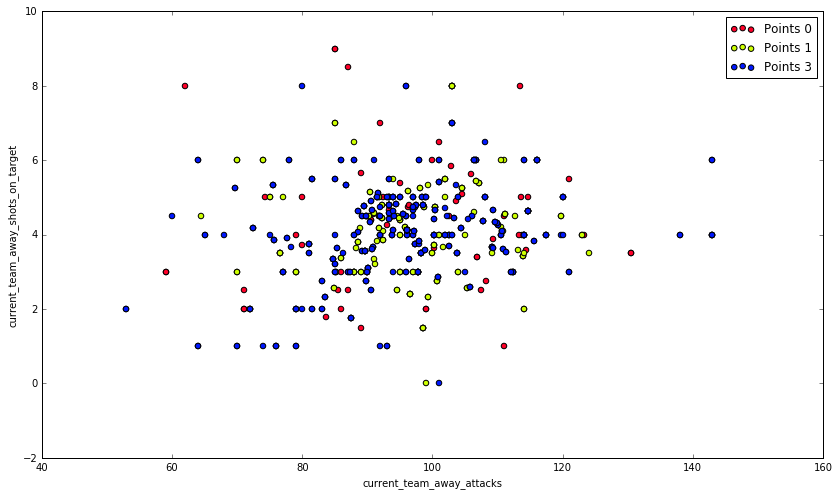

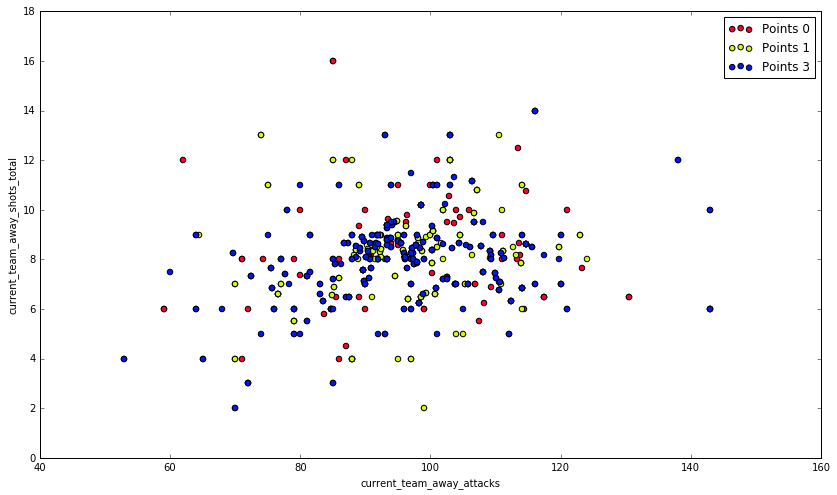

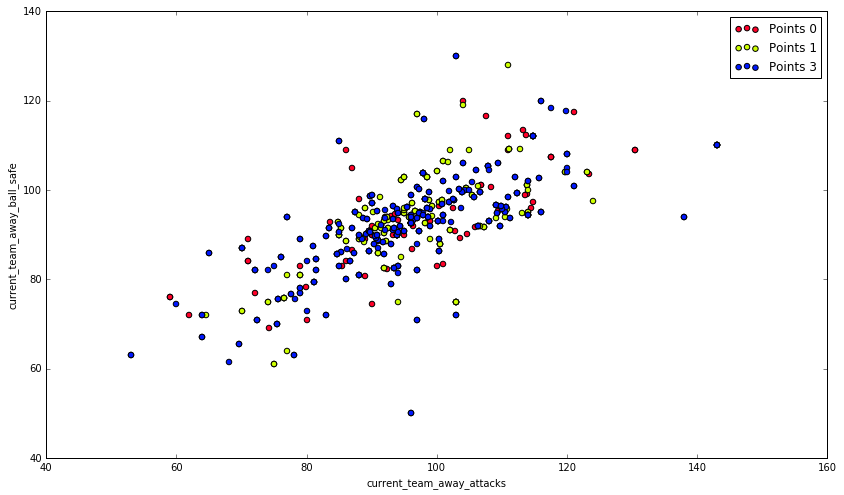

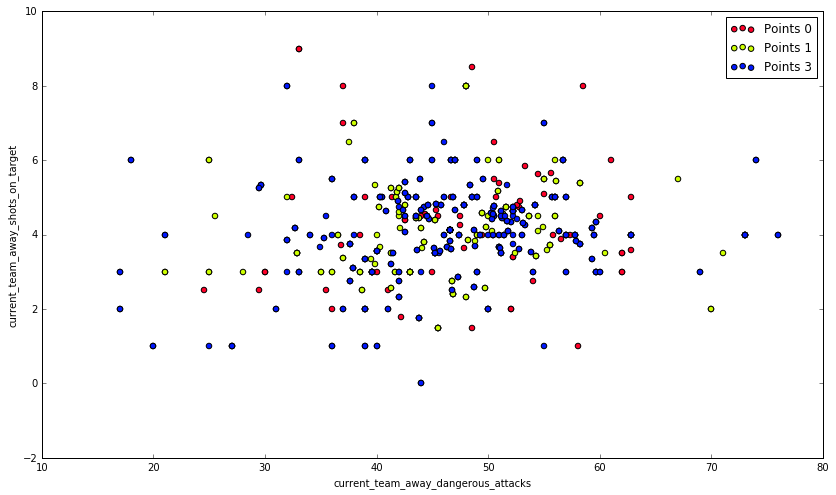

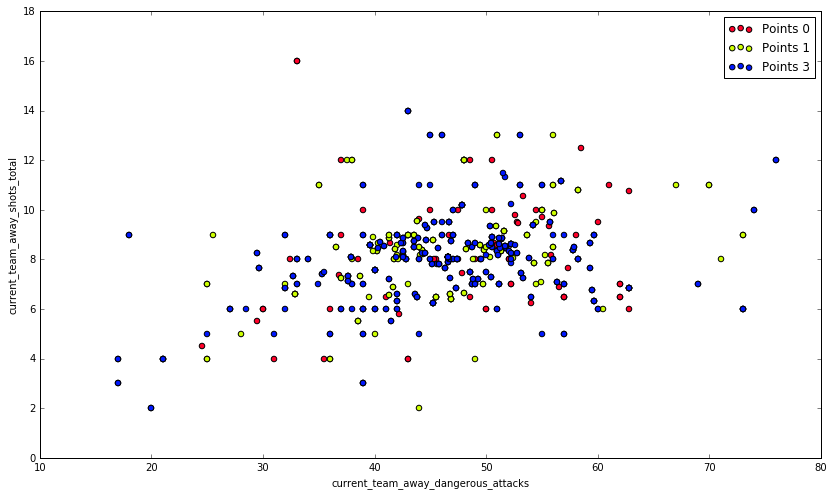

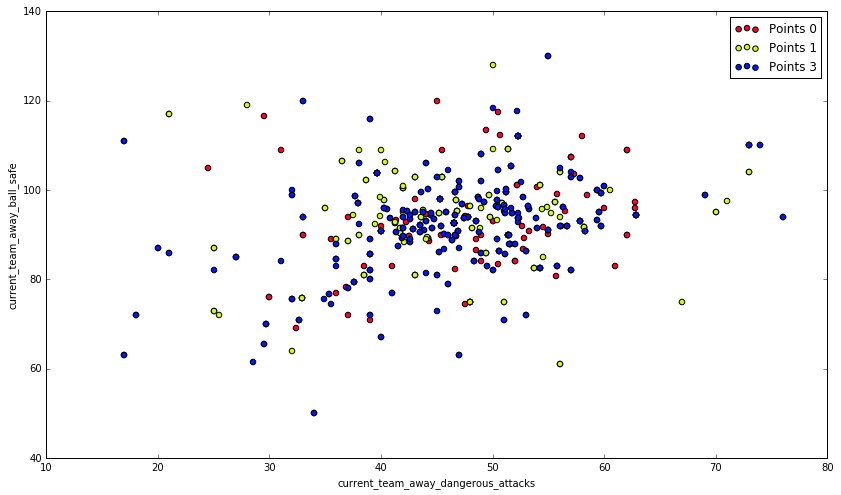

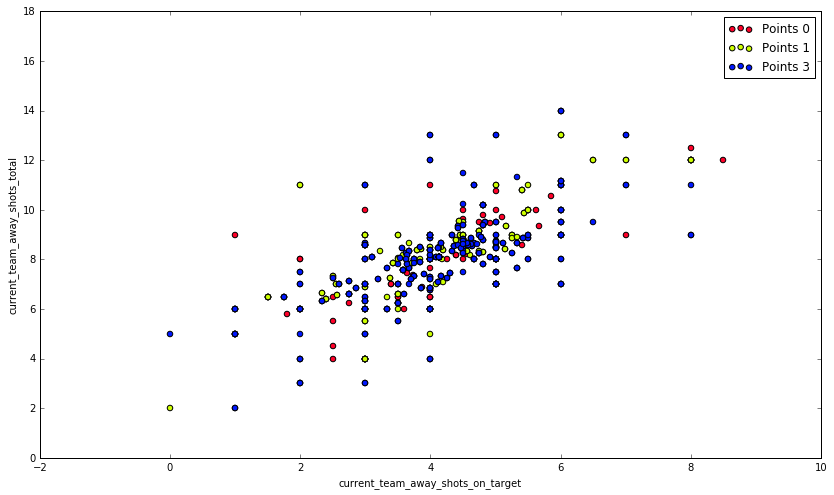

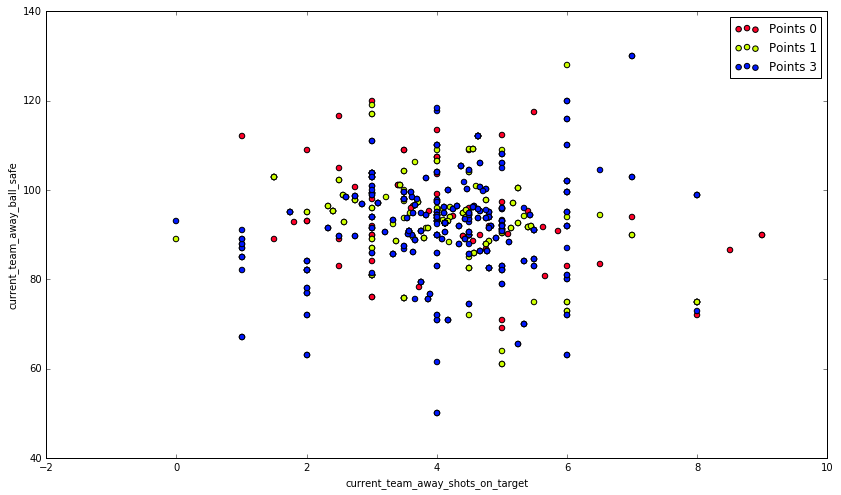

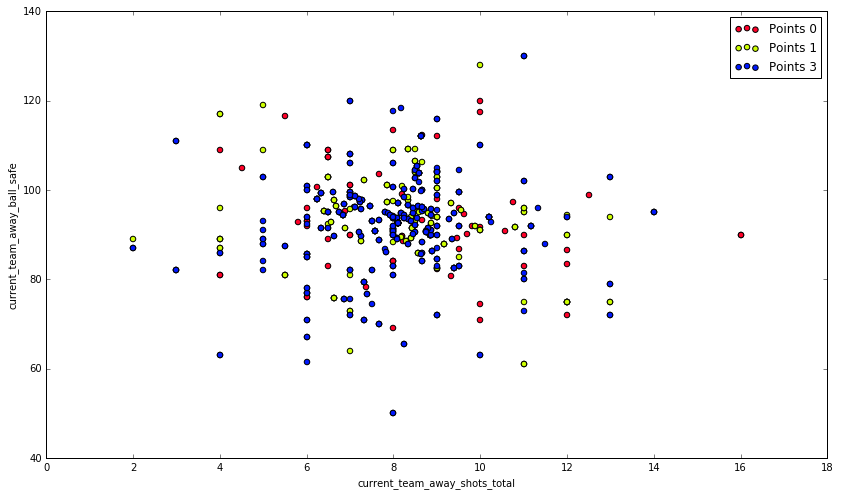

In [61]:
home_columns = ['current_team_home_possession', 'current_team_home_attacks', 'current_team_home_dangerous_attacks', 'current_team_home_shots_on_target', 'current_team_home_shots_total', 'current_team_home_ball_safe', 
           'points']

away_columns = ['current_team_away_possession', 'current_team_away_attacks', 'current_team_away_dangerous_attacks', 'current_team_away_shots_on_target', 'current_team_away_shots_total', 'current_team_away_ball_safe', 
           'points']
extended_features = raw_data[away_columns]
display(extended_features.head())

for c in range(len(away_columns)):
    if c < (len(away_columns)-1): 
        compare = (len(away_columns)-2) - c
        for x in (range(compare)):
            fig, ax = plt.subplots(figsize = (14,8))
            cmap = cm.get_cmap('gist_rainbow')

            for i, cluster in extended_features.groupby('points'):   
                cluster.plot(ax = ax, kind = 'scatter', x = away_columns[c], y = away_columns[x+1+c], 
                    color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);

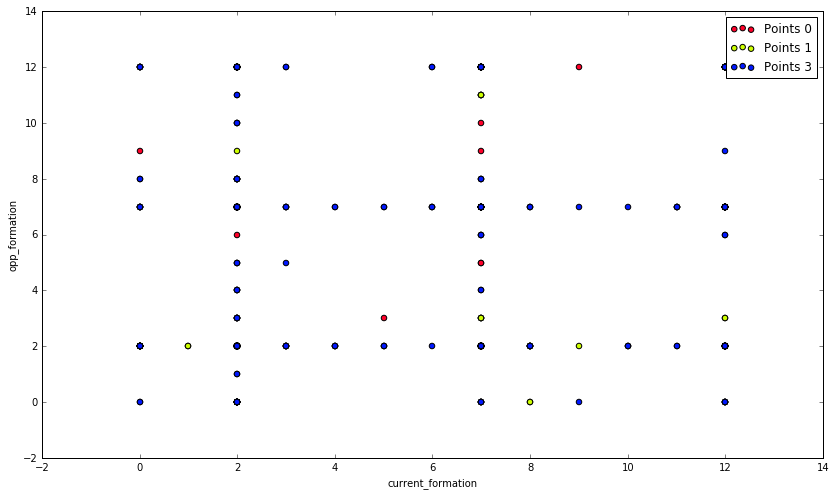

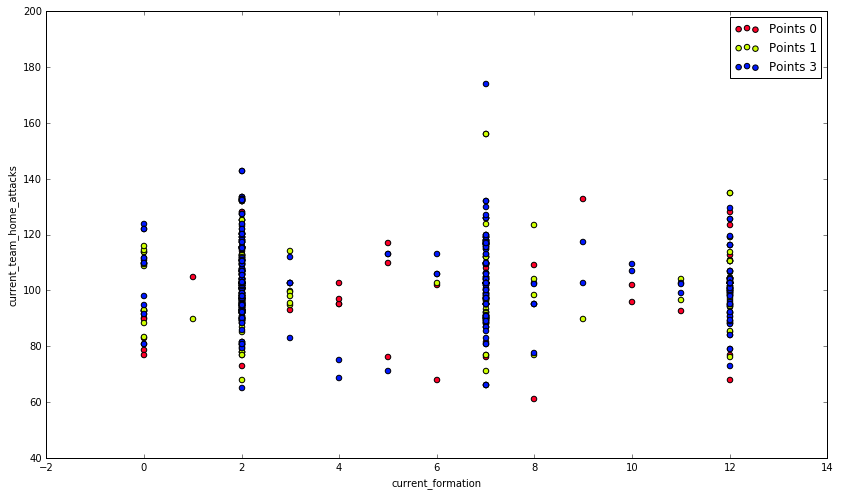

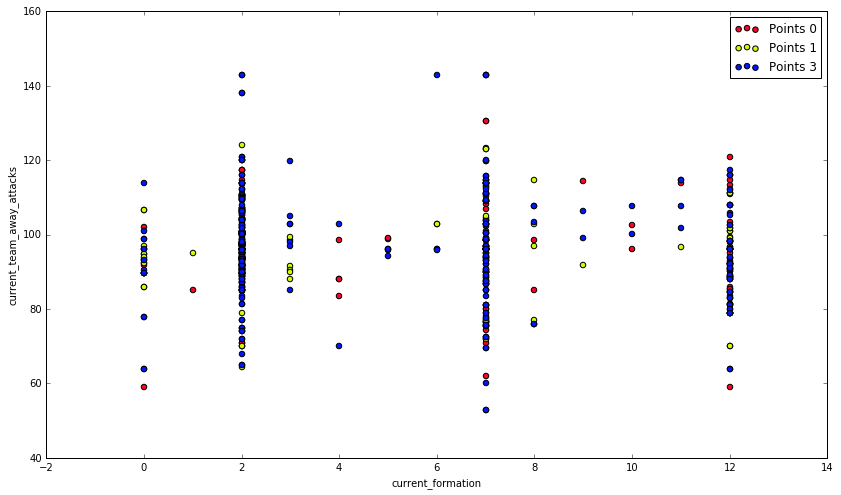

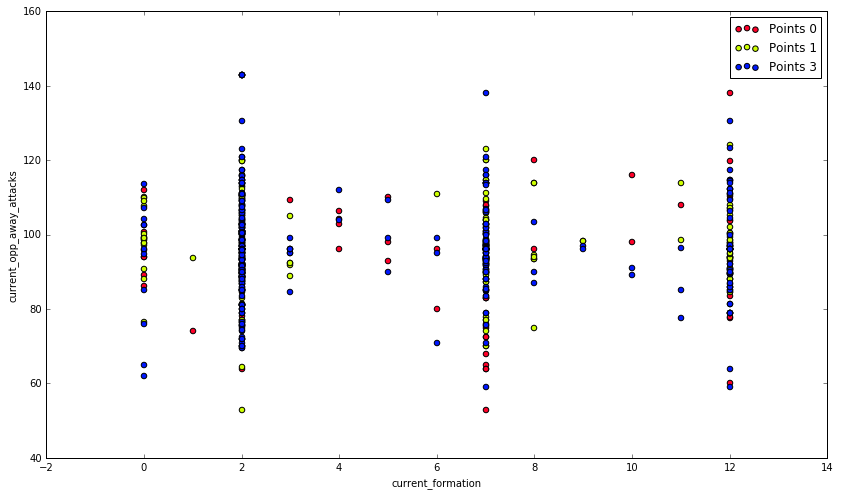

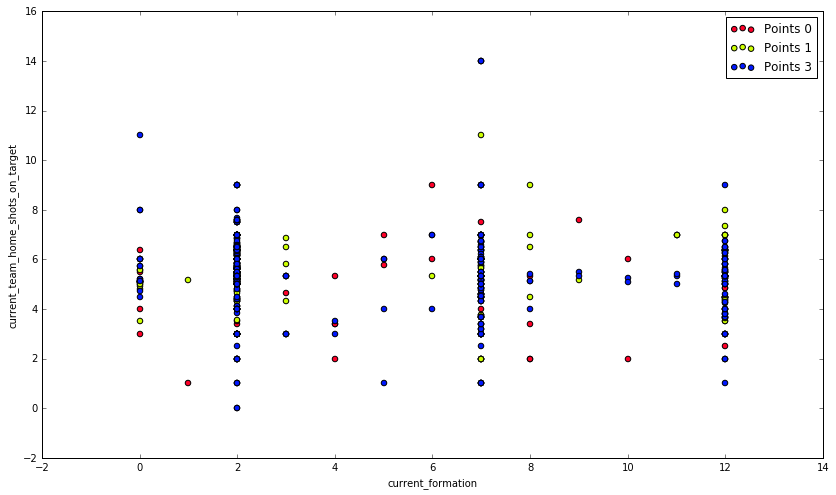

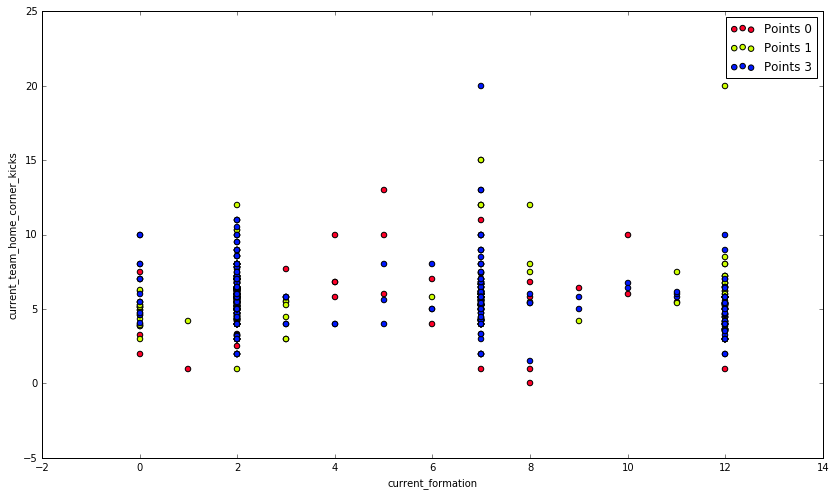

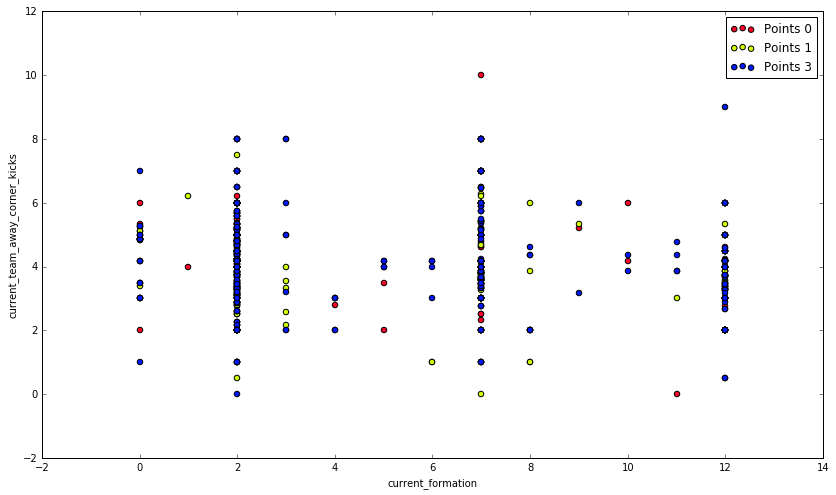

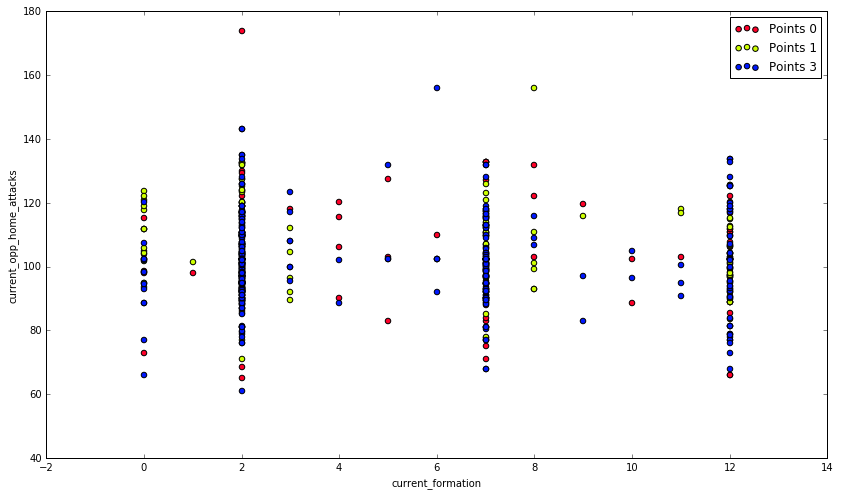

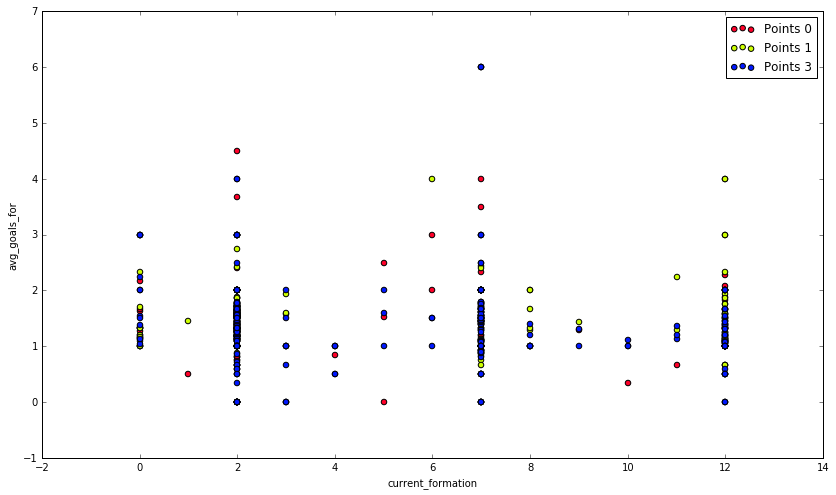

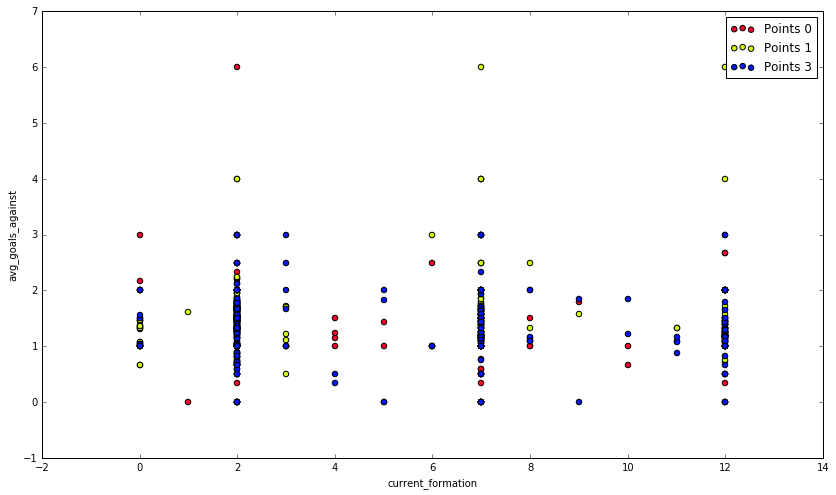

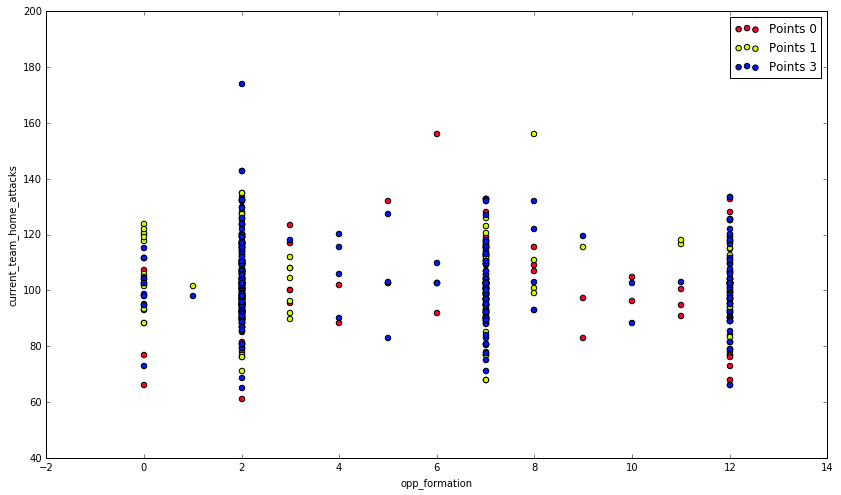

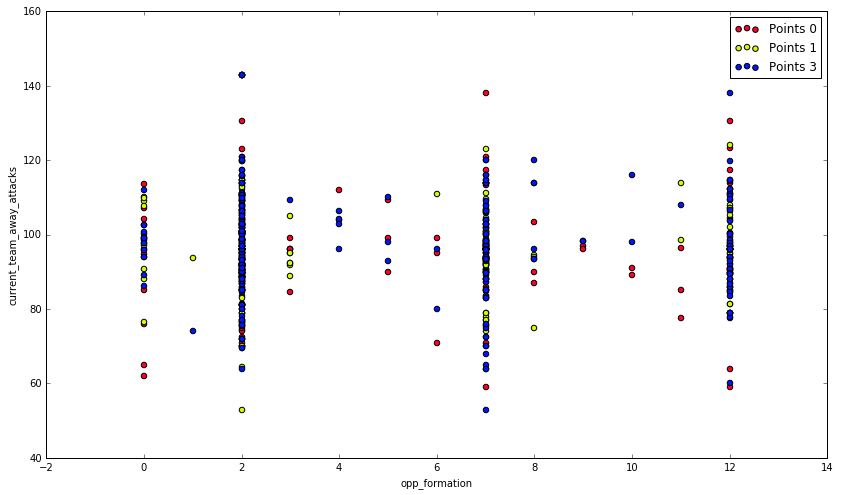

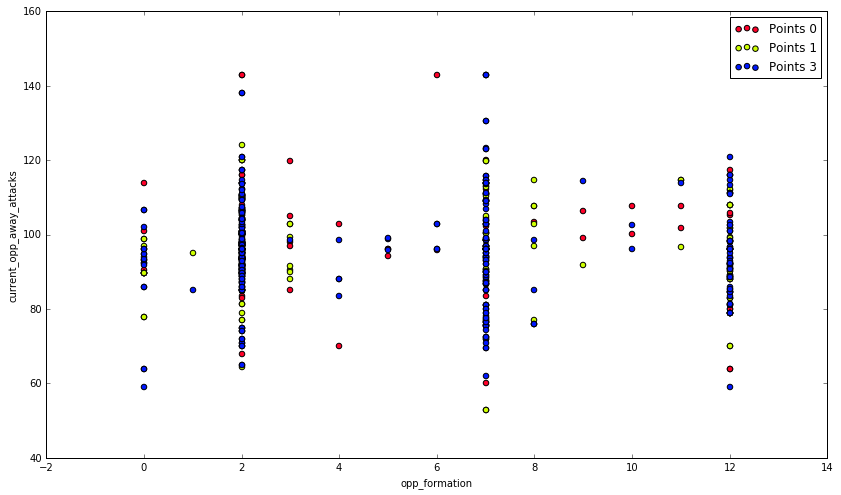

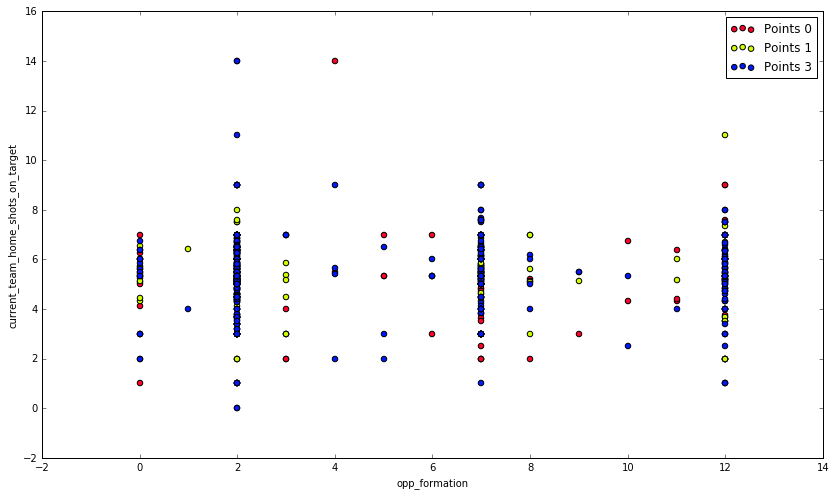

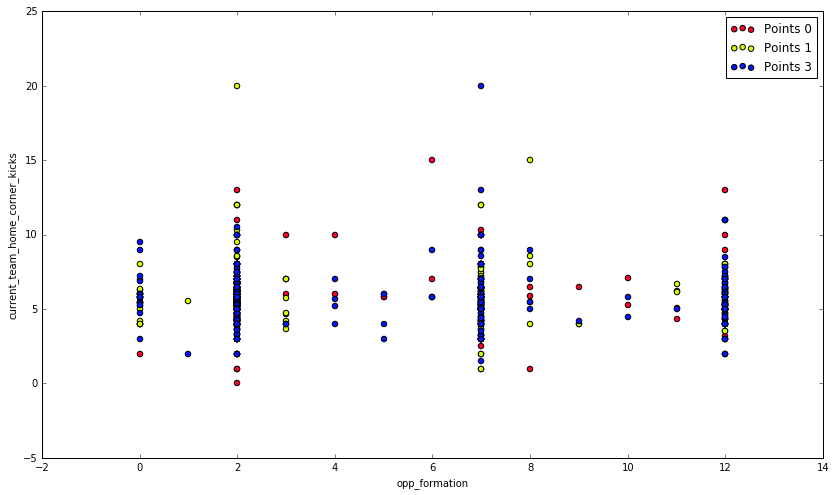

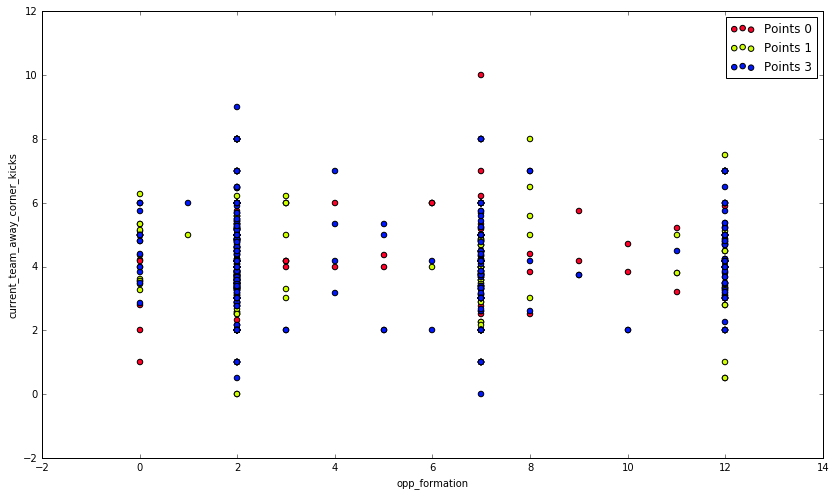

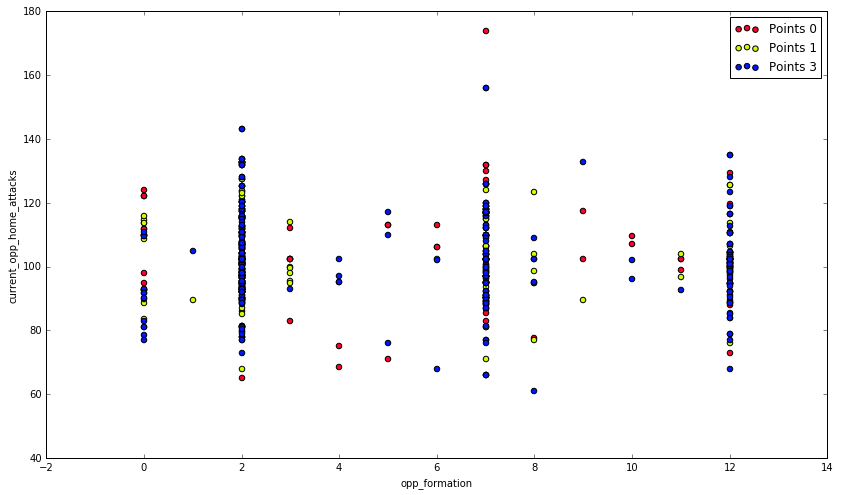

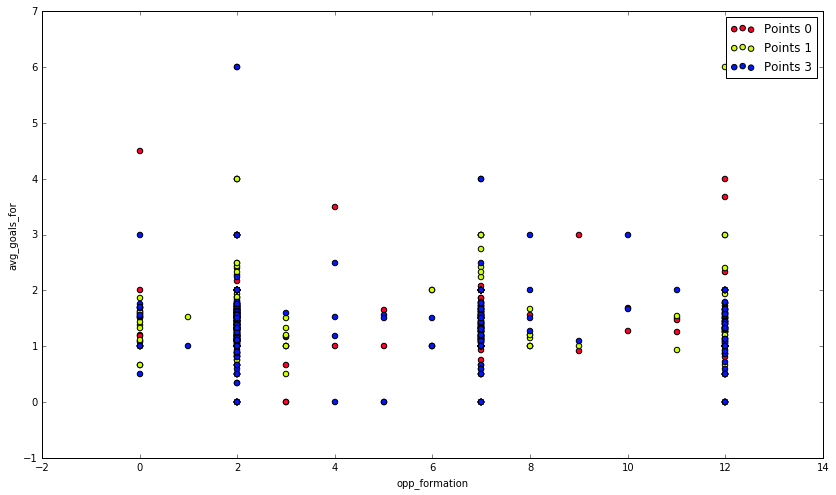

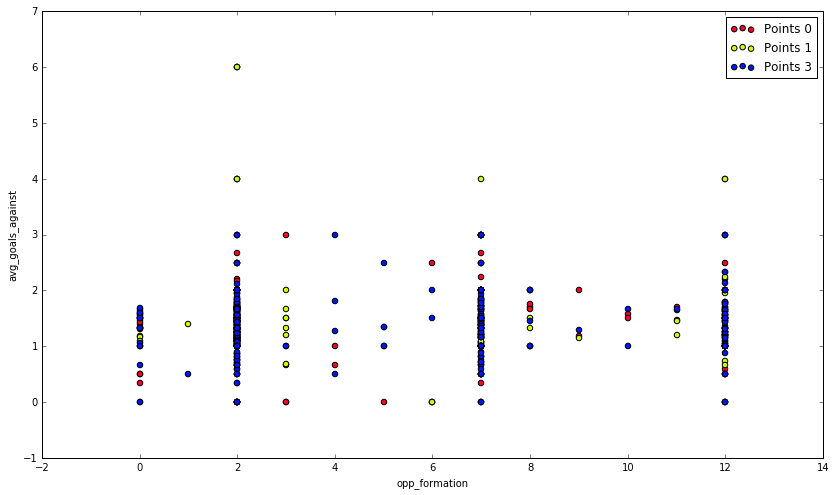

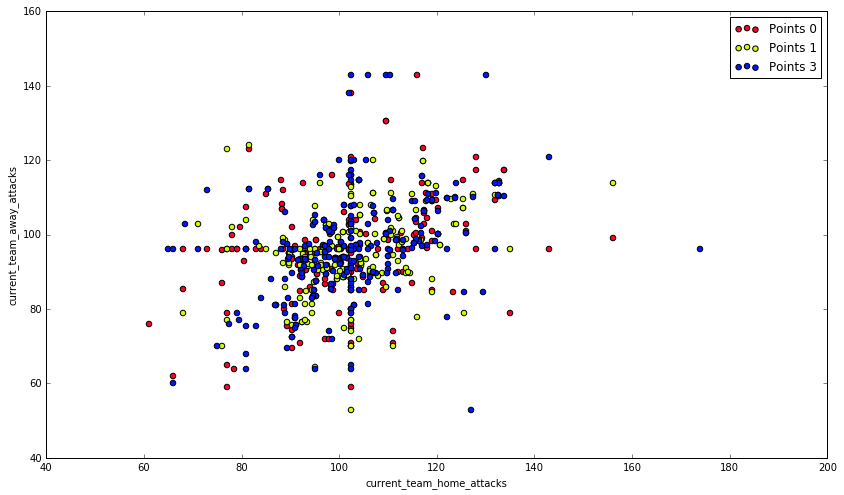

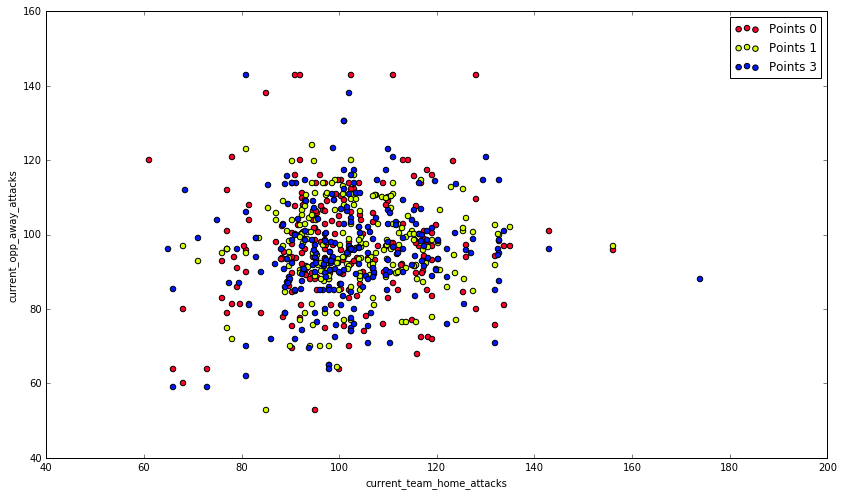

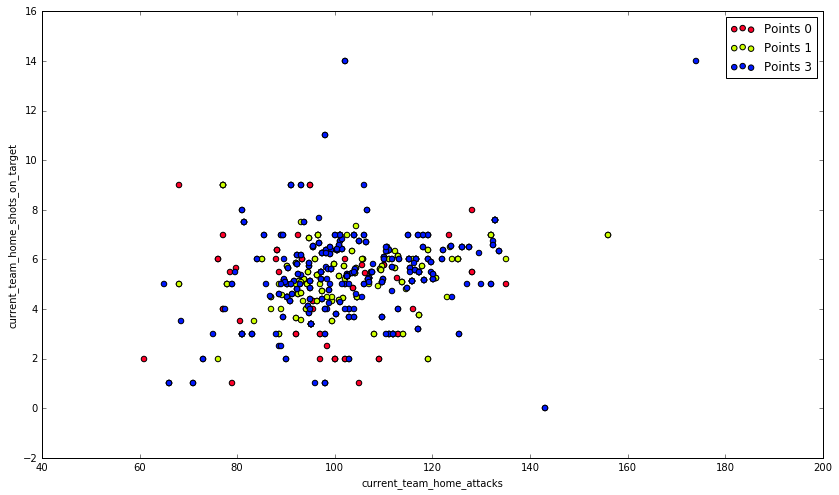

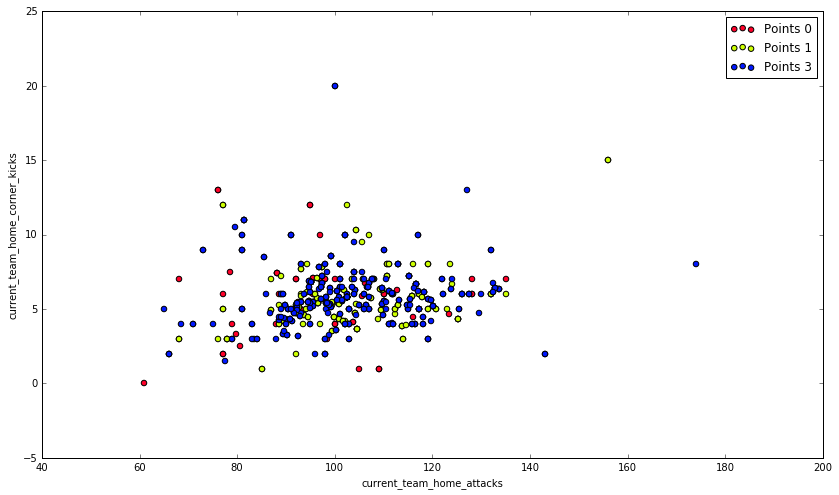

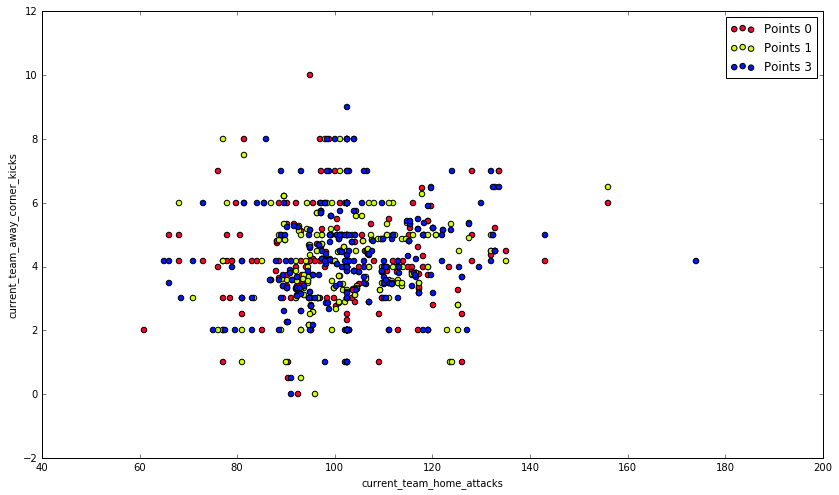

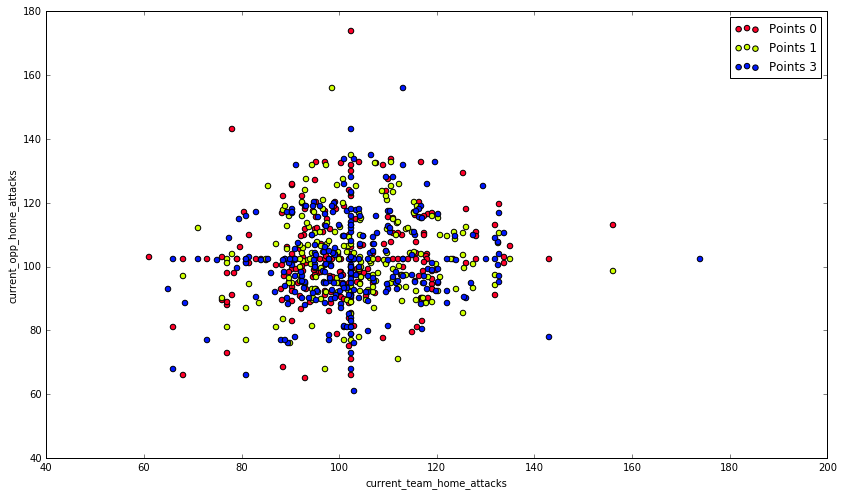

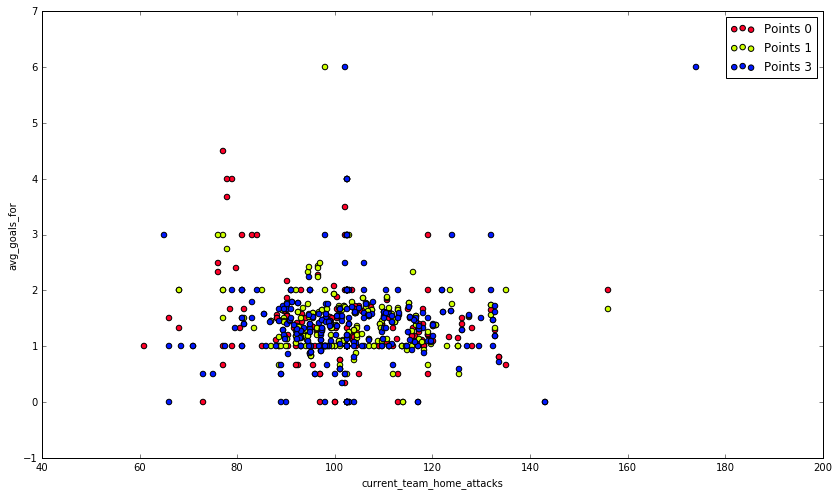

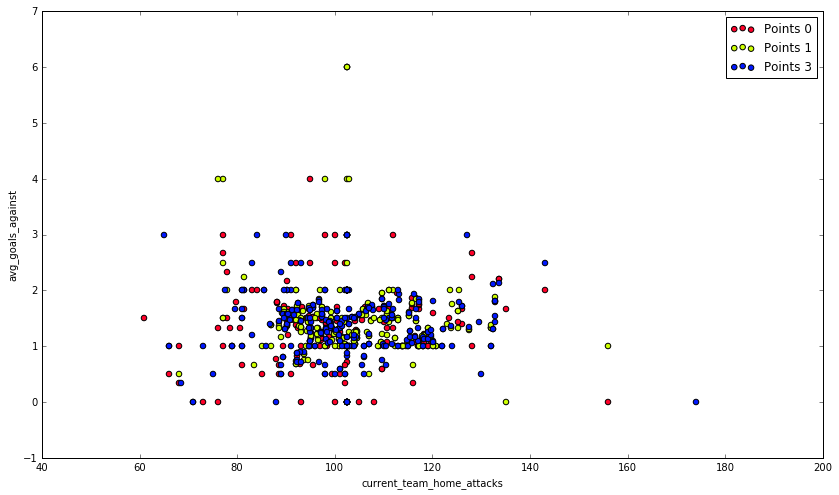

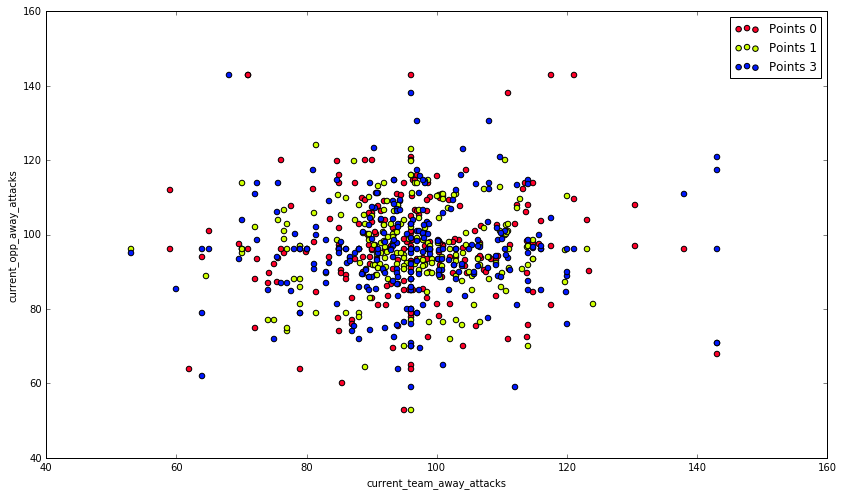

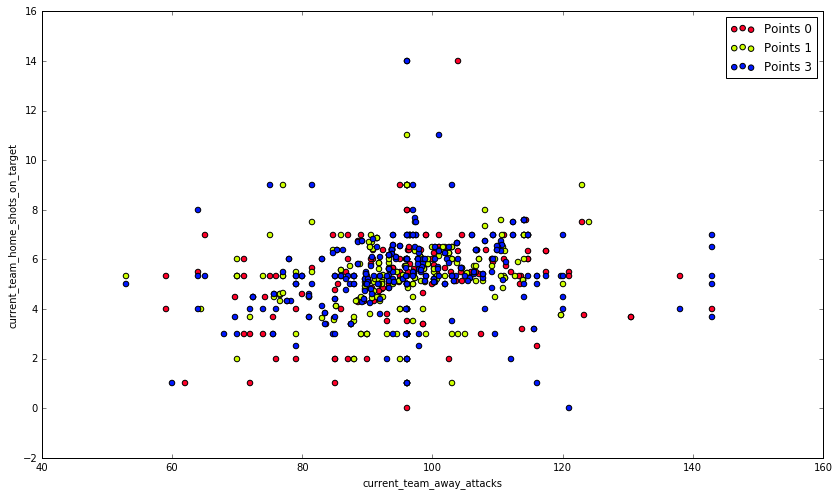

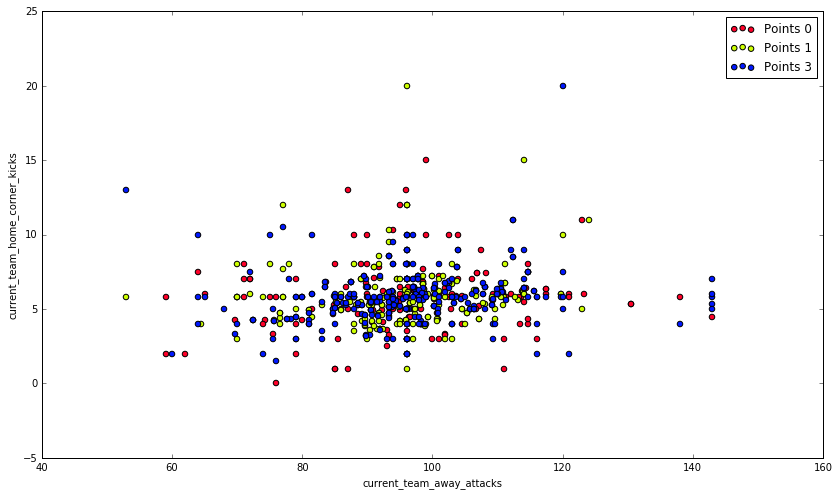

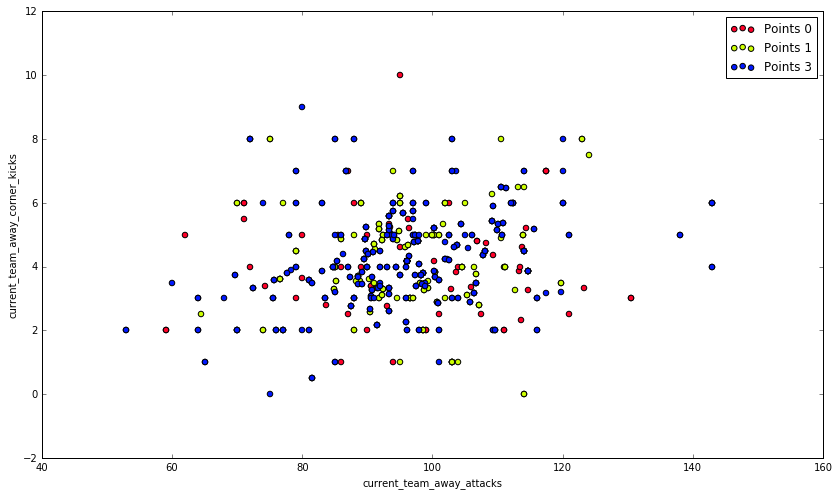

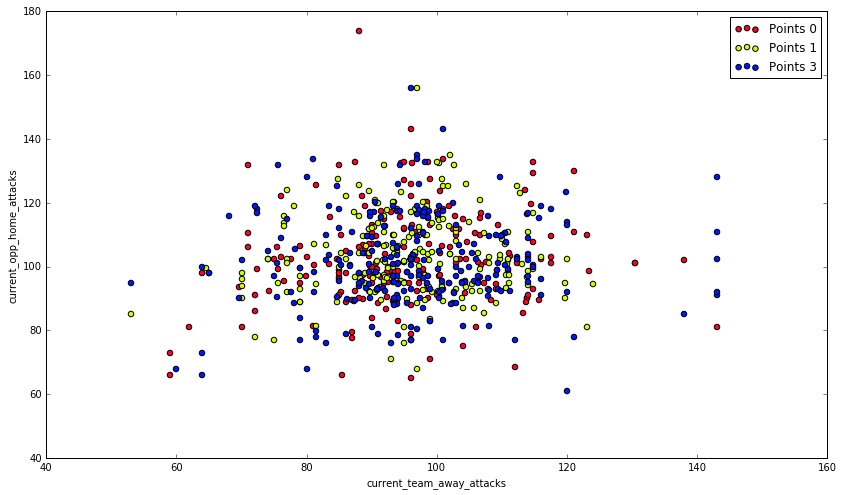

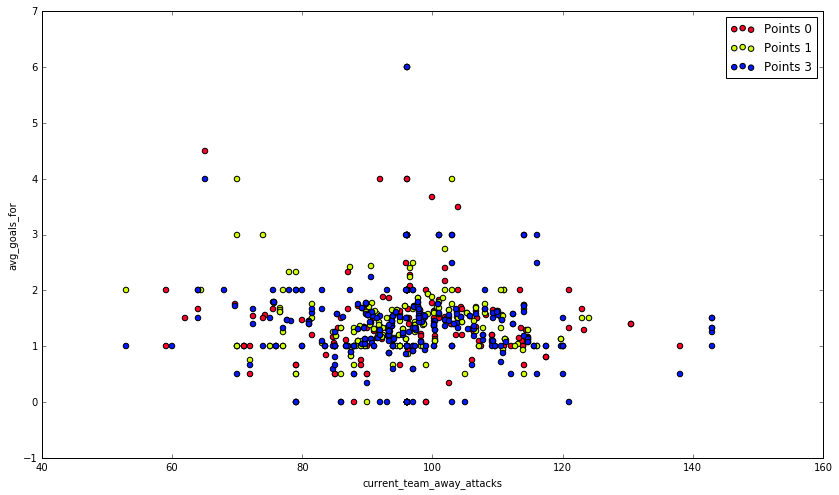

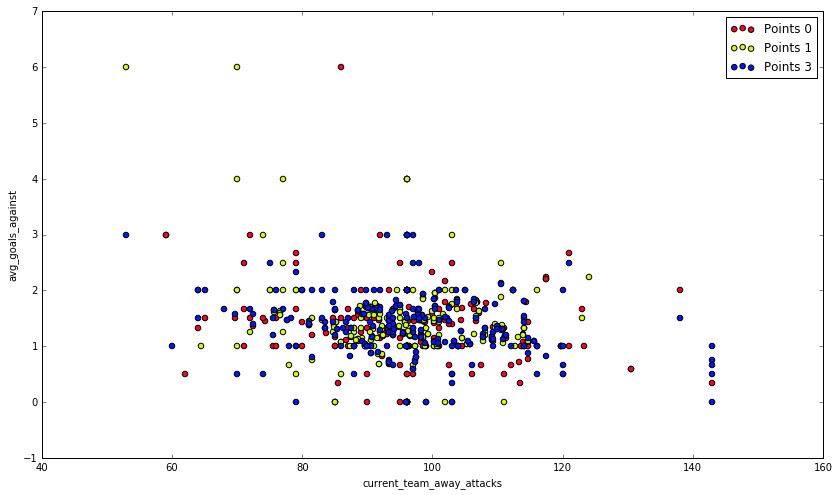

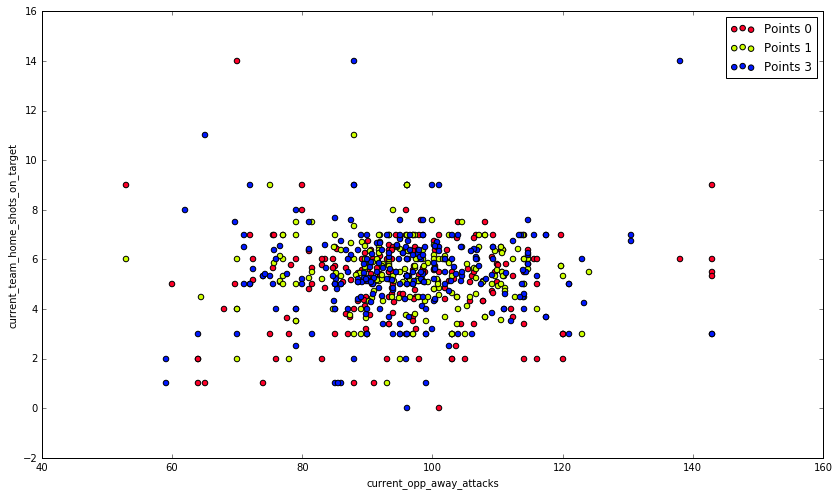

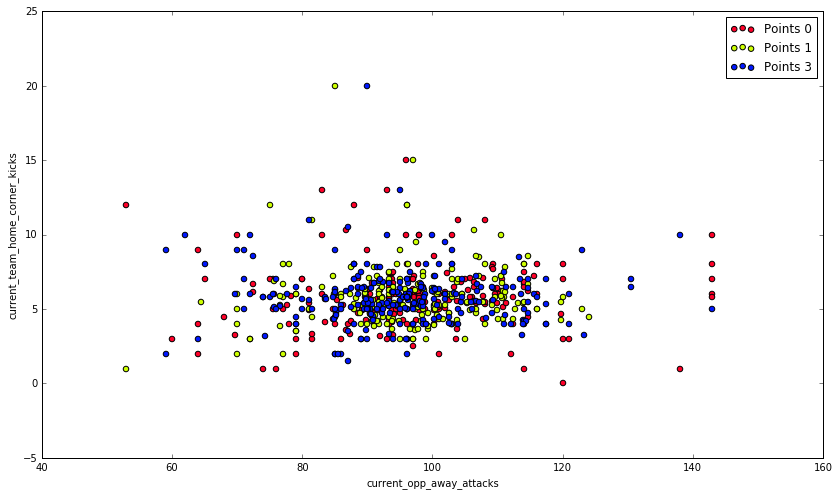

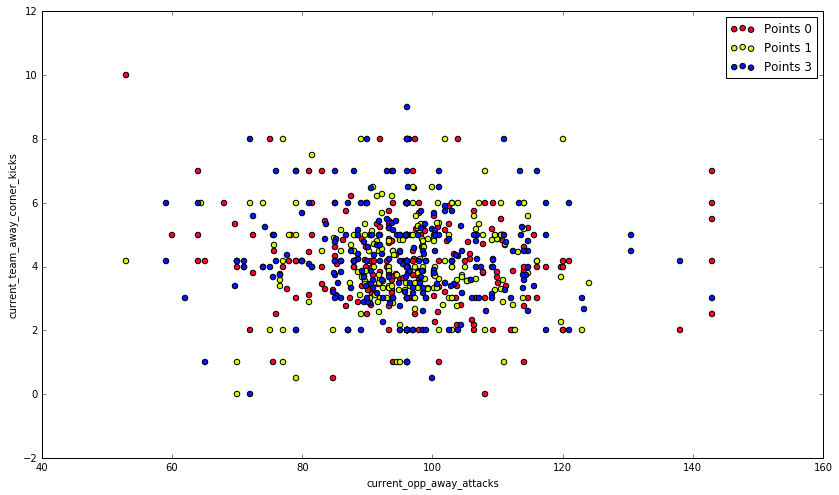

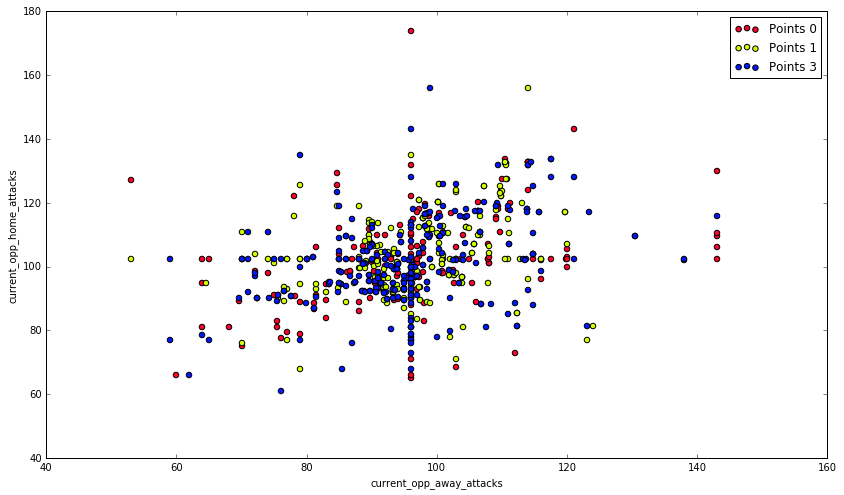

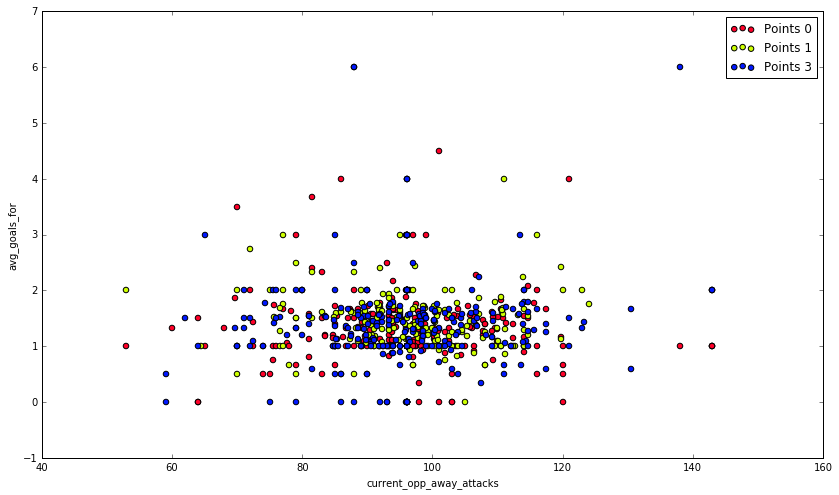

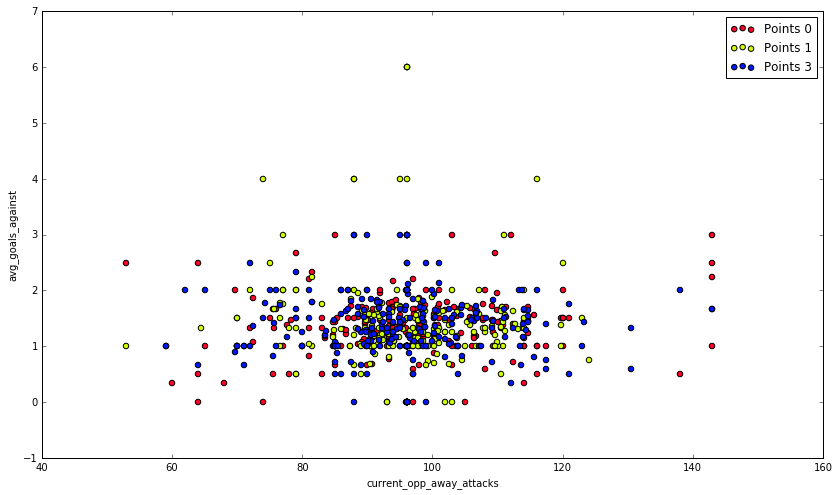

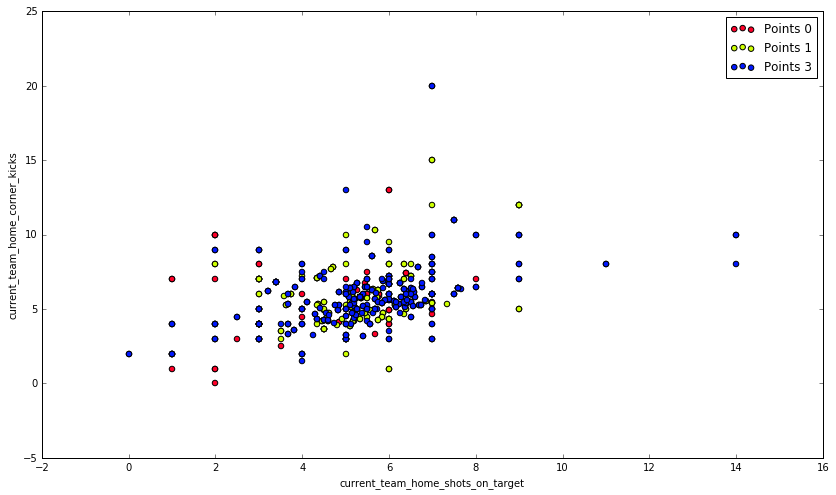

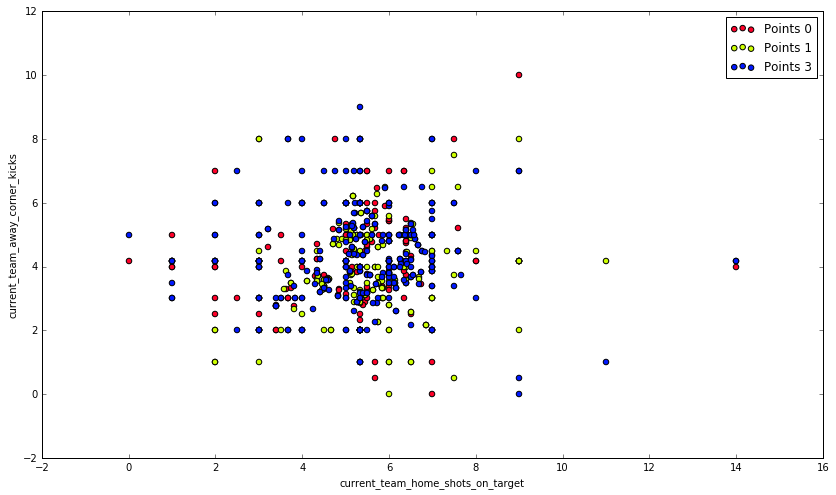

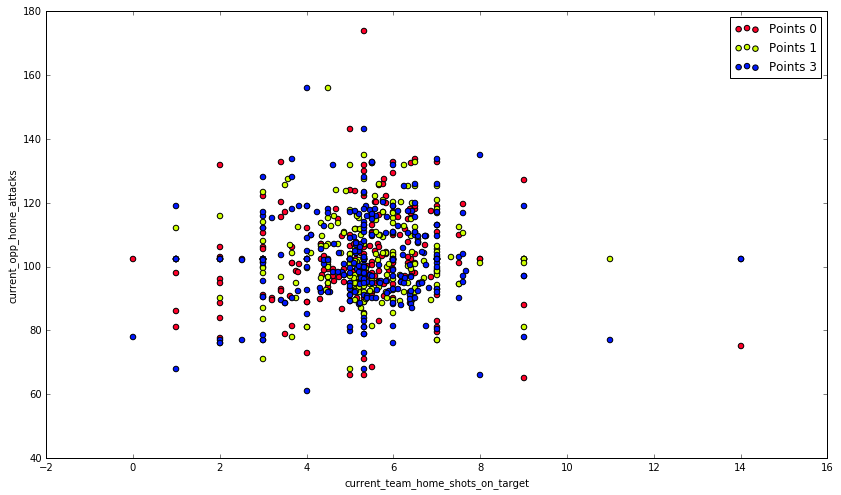

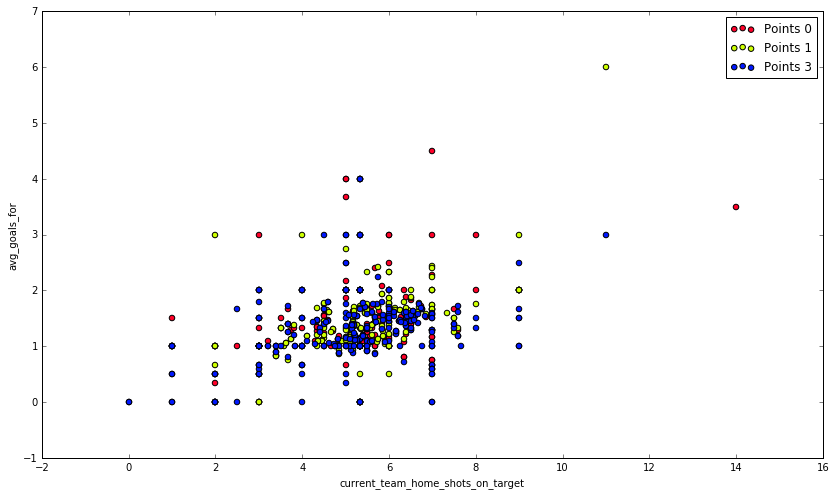

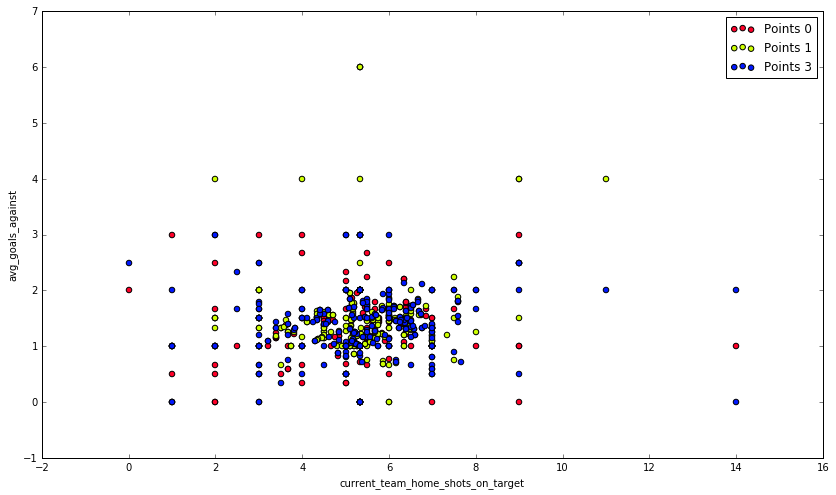

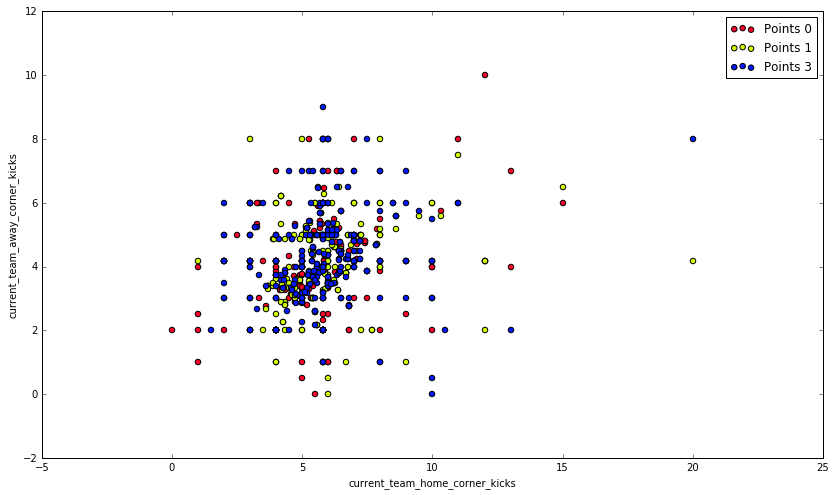

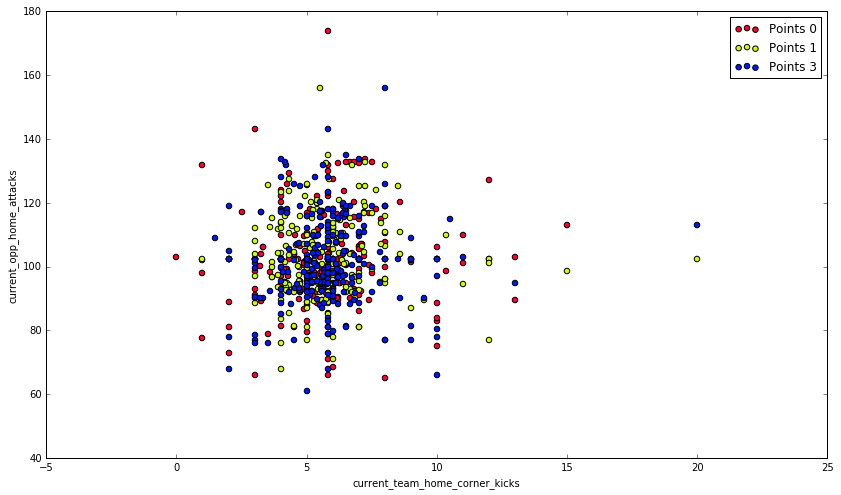

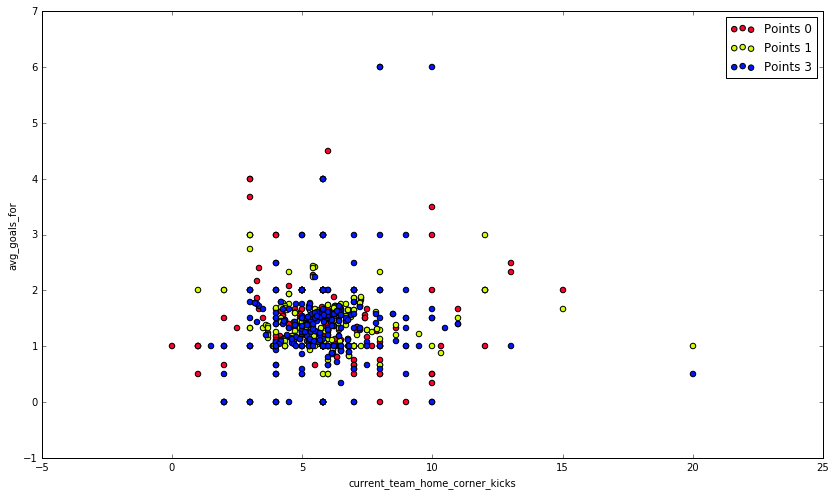

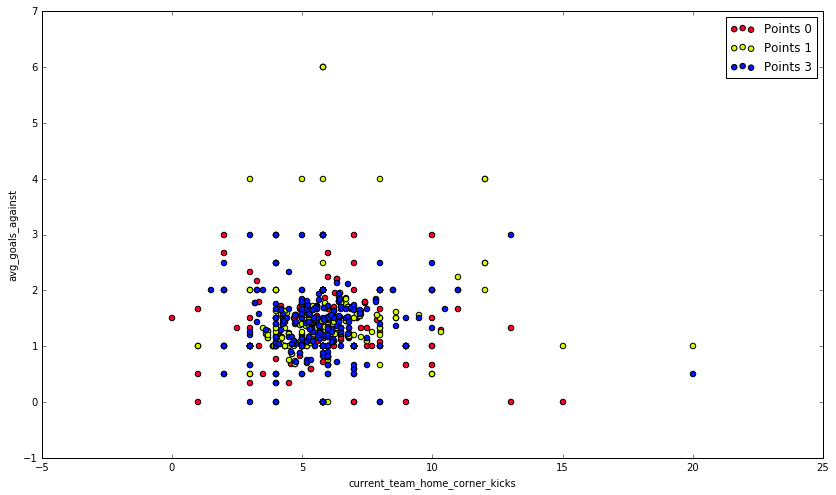

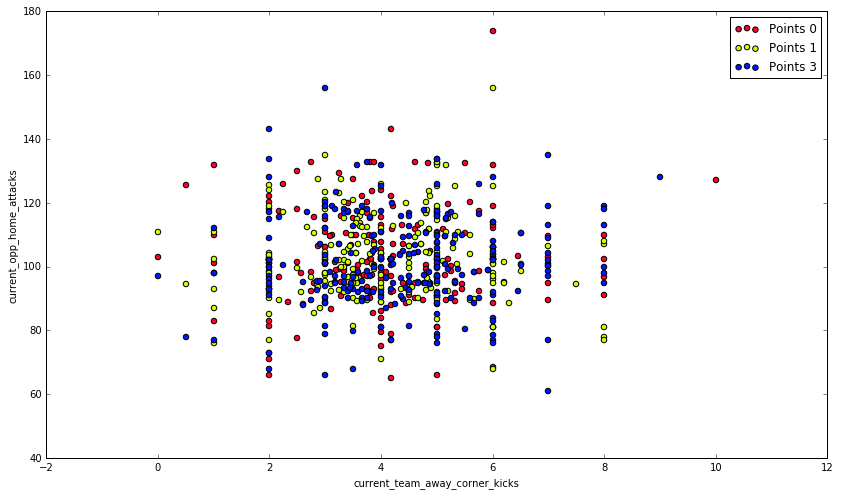

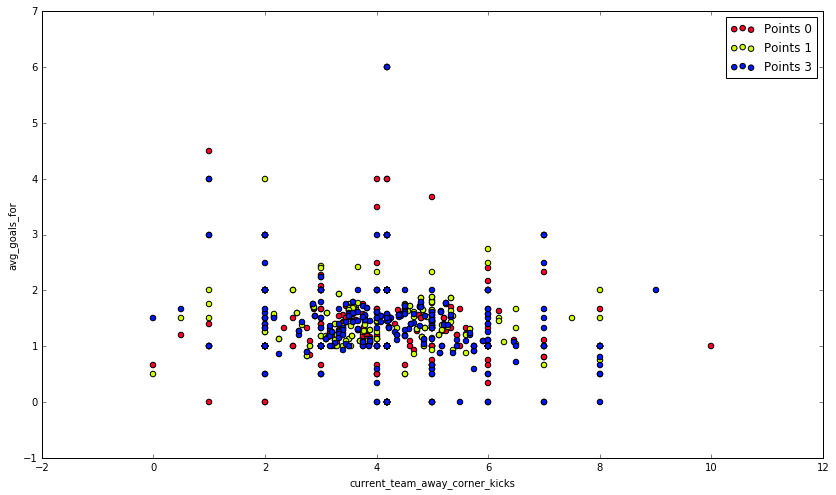

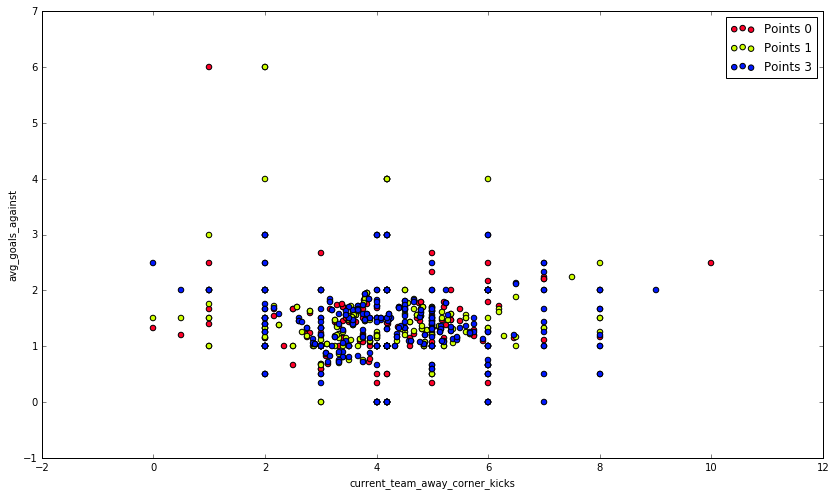

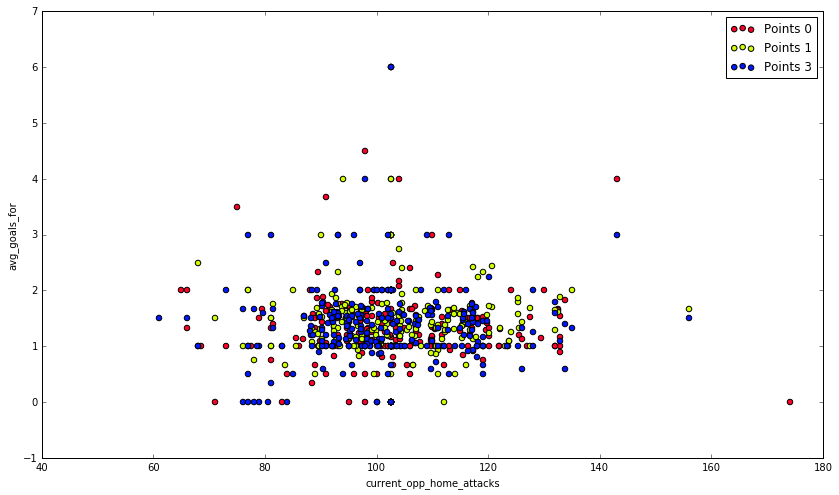

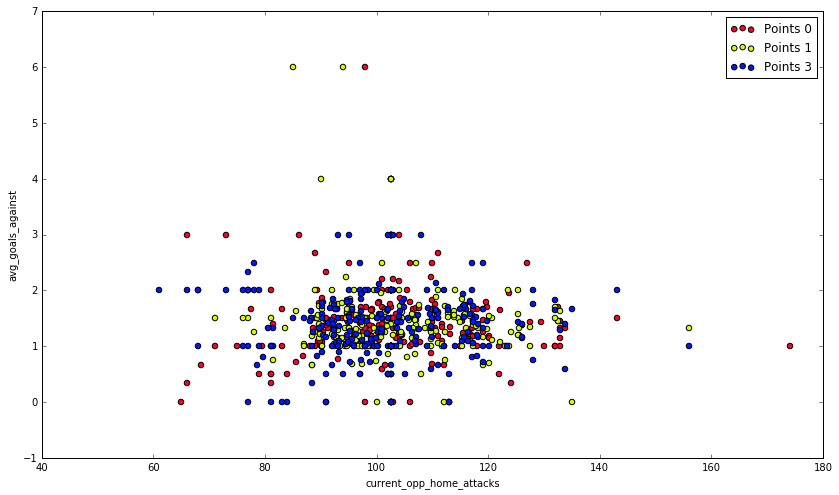

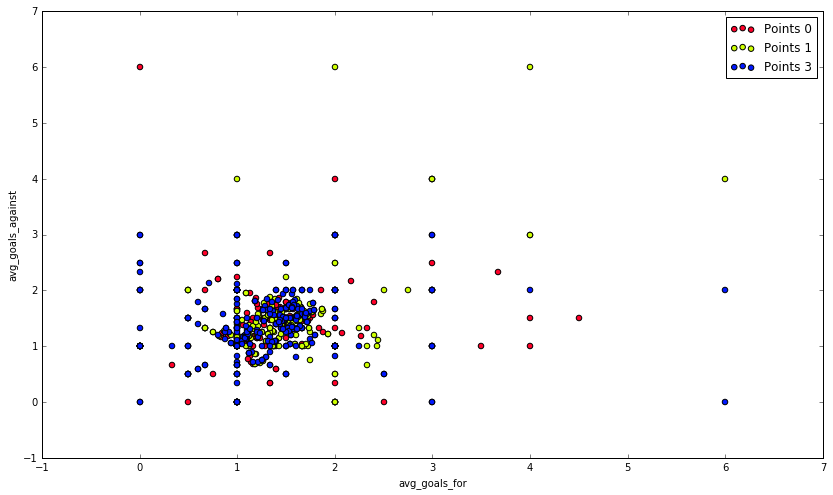

In [70]:
discovery_columns = ['current_formation', 'opp_formation', 'current_team_home_attacks', 'current_team_away_attacks', 'current_opp_away_attacks', 'current_team_home_shots_on_target', 'current_team_home_corner_kicks', 'current_team_away_corner_kicks', 
           'current_opp_home_attacks', 'avg_goals_for', 'avg_goals_against', 'points']

extended_features = raw_data[discovery_columns]

rf = model_libs.reformat_formation(extended_features, extended_features.groupby('current_formation').groups, extended_features.groupby('opp_formation').groups)

for r in range(len(rf)):
    extended_features = extended_features.replace(rf[r], r)

#display(extended_features.head())
#display(extended_features.tail())

for c in range(len(discovery_columns)):
    if c < (len(discovery_columns)-1): 
        compare = (len(discovery_columns)-2) - c
        for x in (range(compare)):
            fig, ax = plt.subplots(figsize = (14,8))
            cmap = cm.get_cmap('gist_rainbow')

            for i, cluster in extended_features.groupby('points'):
                cluster.plot(ax = ax, kind = 'scatter', x = discovery_columns[c], y = discovery_columns[x+1+c], 
                    color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);